In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
from matplotlib import ticker
import numpy as np

from astropy.io import fits

from scipy.signal import convolve2d 
from scipy.signal import convolve
import scipy.interpolate
import scipy.ndimage

import numpy as np
from scipy import constants
from scipy.interpolate import interp1d
import time
from os import path, getcwd
#from os import getcwd
import inspect
from math import pi
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

ator=1/180/3600*np.pi

In [2]:
def set_rcparams_prop(amp=1, fs=22):
#     fs=18
#     fs=22
    tickmajorwidth=2.5
    tickminorwidth=2.5
    axeslw=2.5
    tmjs=6*amp
    tmns=tmjs/3.5*2*amp
    plt.rcParams['axes.titlesize']=fs
    plt.rcParams['axes.labelsize']=fs
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    plt.rcParams['axes.linewidth'] = axeslw
    plt.rcParams['xtick.major.width'] = tickmajorwidth
    plt.rcParams['ytick.major.width'] = tickmajorwidth
    plt.rcParams['xtick.minor.width'] = tickminorwidth
    plt.rcParams['ytick.minor.width'] = tickminorwidth
    plt.rcParams['xtick.major.size'] = tmjs
    plt.rcParams['ytick.major.size'] = tmjs
    plt.rcParams['xtick.minor.size'] = tmns
    plt.rcParams['ytick.minor.size'] = tmns

In [3]:
def interp(wave, value, xnew, itpkind='cubic', itpfillvalue="extrapolate"):
    itpfunc=interp1d(wave, value, 
                                       kind=itpkind, fill_value=itpfillvalue)
    return itpfunc

def return_spatial(cat_str, wave, fx, fy, pscale):
    cdir='./macro_result'
    data_file=cdir+'/'+cat_str+'.txt'
#     print(cat_str)

    datacol=1
    skiprows=0

    data=np.loadtxt(data_file, usecols=(0,1,2,3), dtype=float,
                    skiprows=skiprows)
    
    ftol=1/3600
    cond=(np.abs(data[:,1]-fx) < ftol) & (np.abs(data[:,2]-fy) < ftol)
    
    itpwave=(data[:,0])[cond]/10
    itpvals=(data[:,3])[cond]
    
    sortidx=np.argsort(itpwave)
    itpfunc=interp(itpwave[sortidx], itpvals[sortidx],wave)
#     print(data[:,1])
    return(itpfunc(wave)*2/pscale)
    
def return_spectral(cat_str, wave, fx, fy, dispersion):
    cdir='./macro_result'
    data_file=cdir+'/'+cat_str+'.txt'
#     print(cat_str)

    datacol=1
    skiprows=0

    data=np.loadtxt(data_file, usecols=(0,1,2,3), dtype=float,
                    skiprows=skiprows)
    ftol=1/3600
    cond=(np.abs(data[:,1]-fx) < ftol) & (np.abs(data[:,2]-fy) < ftol)
    
    itpwave=(data[:,0])[cond]/10
    itpvals=(data[:,3])[cond]
    
    sortidx=np.argsort(itpwave)
    itpfunc=interp(itpwave[sortidx], itpvals[sortidx],wave)
#     print(data[:,1])
#     print(itpfunc(wave))
    return(wave/(2*itpfunc(wave)*dispersion))

def return_data(skind,cwave,aper, wave, fx, fy, pscale, dispersion):
    cdir='./macro_result'
    fname='_'.join([skind,'c'+cwave,''+aper])
    data_file=cdir+'/'+fname+'.txt'
#     print(cat_str)

    datacol=1
    skiprows=0

    data=np.loadtxt(data_file, usecols=(0,1,2,3), dtype=float,
                    skiprows=skiprows)
    ftol=1/3600
    cond=(np.abs(data[:,1]-fx) < ftol) & (np.abs(data[:,2]-fy) < ftol)
    
    itpwave=(data[:,0])[cond]
    itpvals=(data[:,3])[cond]
    
    sortidx=np.argsort(itpwave)
    itpfunc=interp(itpwave[sortidx], itpvals[sortidx],wave)
#     print(data[:,1])
#     print(itpfunc(wave))
    if skind=='spat':
        return(itpfunc(wave)*2/pscale)
    if skind=='spec':
        return(wave/(2*itpfunc(wave)*dispersion))
    

def plot_dlimit(ax,skind,cwave,aper, wave, fx, fy, pscale, dispersion):
    dlsty=[':']
#     fwhms=np.array([25,35,40,50])
#     fwhms=np.array([25,35,50])
    fwhms=np.array([35])
    for i in range(len(fwhms)):
        if skind=='spat':
            limit=fwhms[i]/pscale
        if skind=='spec':
            limit=int(cwave)/(fwhms[i]*dispersion)
        print(limit)
#         ax.axhline(limit, linestyle=dlsty[i], color='k', lw=2)
    return limit

0.7757018897752576 0.014888799999999999
0.0 2513.6180221356144
0.25 2042.4032710186593
0.375 1674.9184681956124
1984.2335945715668
0.0 19.710617295577705
0.25 29.436201454432265
0.375 39.815006750260814


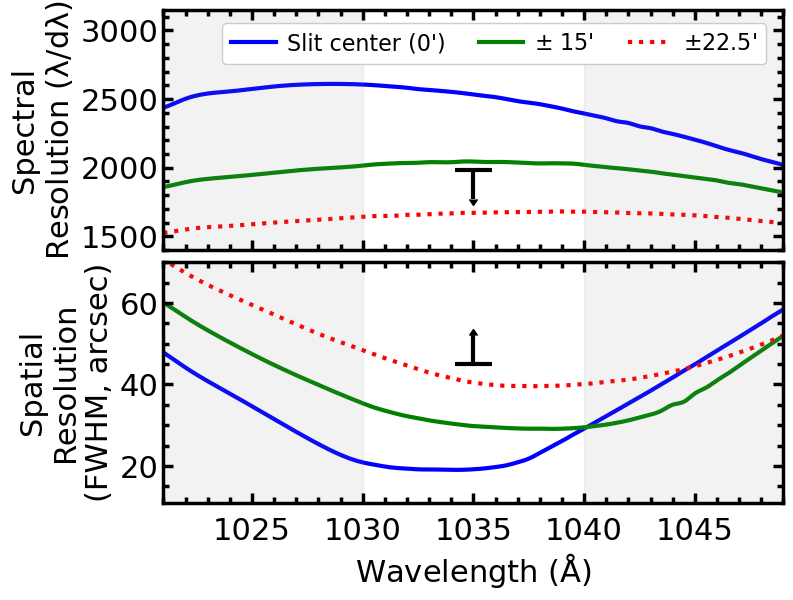

In [4]:
# wave=np.arange(200)/200*3+102
wave=(np.arange(200)/200*3+102)*10
set_rcparams_prop(amp=1.15)

rr=0.8
fig = plt.figure(figsize=(10*rr, 8*rr))
gs1=gridspec.GridSpec(2,1, 
#                       left=0.15, bottom=0.1, right=0.95,top=0.82,
                      wspace=None, hspace=0)
gs1.update(hspace=0.05)
ax=plt.subplot(gs1[0])

wcent=1035
woff=4
wint=[wcent-woff,wcent+woff]
wint=[1030,1040]
wr=14
xr=[wcent-wr,wcent+wr]
lw=3

lsyts=['-','-',':','-']
lws=[3,3,3]
clrs=['b','g','r','k']
fxs=(np.arange(4)*150-225)/3600
# fxs=(np.arange(4)*60-90)/3600
# fxs=(np.arange(1)*60-30)/3600
fxs=np.ones(4)*(-30)/3600
# fxs=np.zeros(4)
fl=160
pscale=(fl*1000/(180*3600/np.pi))
dispersion=0.00148888*140/(300-fl)*10
print(pscale, dispersion)
skind='spat'
skind='spec'
cwave='1034'
# cwave='1040'
# aper='a5050'
# aper='a4040'
# aper='ap4060'
# aper='a4060'
aper='ap4050'
aper='app4050'
# aper='apf4050'
# aper='a4050'
# fys=np.ones(4)*(0/2/60)
# fys=np.ones(4)*(30/2/60)
# fys=np.ones(4)*(0/2/60)
fys=(np.arange(3))*(20/60)/2
fys=np.array([0,15,22.5])/60
# 0.78,0.001488
lbs=["Slit center (0')",r'$\pm$'+" 15'",r'$\pm$'+"22.5'"]
for i in range(len(fys)):
#     print('aa',i)
#     lb=str(fxs[i])+'  '+str(fys[i])
    lb=lbs[i]
    val=return_data(skind,cwave,aper,wave, fxs[i], fys[i], pscale, dispersion)
    
    
    func=interp1d(wave, val, kind='cubic', assume_sorted=False)
    print(fys[i],func(1036))
    
    ax.plot(wave, val, linestyle=lsyts[i],color=clrs[i],lw=lws[i], label=lb, zorder=1)


ax.set_ylabel('Spectral\nResolution ('+r'$\rm\lambda/d\lambda$'+')')
dlim=plot_dlimit(ax, skind,cwave,aper, wave, fxs[i], fys[i], pscale, dispersion)

pad=0
ax.set_xticklabels([])
ax.tick_params(axis='y', which='both', direction='in', left=True, right=True)
ax.tick_params(axis='x', which='both', direction='in', top=True, bottom=True, pad=pad)

minorLocator = MultipleLocator(1)
ax.xaxis.set_minor_locator(minorLocator)

minorLocator = MultipleLocator(100)
ax.yaxis.set_minor_locator(minorLocator)
    
ax.set_xlim(xr)
yr=[1400,2950]
yr=[1400,3150]
# yr=[400,3150]
ax.set_ylim(yr)

yticks=np.arange(4)*500+1500
ax.set_yticks(yticks)

woff=20
spanalpha=0.1
spancolor='grey'
ax.axvspan(wint[0]-woff, wint[0], alpha=spanalpha, color=spancolor)
ax.axvspan(wint[1], wint[1]+woff, alpha=spanalpha, color=spancolor)
    

uplims = [True]
lolims = [False]
slimx, slimy=wcent, dlim
sxerr, syerr=[np.abs(xr[1]-xr[0])*0.03], [np.abs(yr[1]-yr[0])*0.12]
ax.errorbar(slimx, slimy, xerr=sxerr, yerr=syerr, uplims=uplims, lolims=lolims, lw=3,
             color='k')
    
bba=0.99
leg=ax.legend(framealpha=1,  fontsize=16, handletextpad=0.5, ncol=3,
              columnspacing=1.5,
              loc='upper right',bbox_to_anchor=(bba ,bba))
    
    
    
    
    
    
    
    
    
# ax2=fig.add_subplot(2,1,2, zorder=0)
ax2=plt.subplot(gs1[1])
fl=225
fl=160
# fl=140
cwave='1034'
pscale=(fl*1000/(180*3600/np.pi))
dispersion=0.00148888*140/(300-fl)*10
aper='c4050'
aper='ap4060'
aper='ap4050'
aper='app4050'
# aper='apf4050'
skind='spat'
# aper='a4040'
# fxs=np.ones(4)*(-30)/3600

lbs=['Slit center',r'$\pm$'+" 15'",r'$\pm$'+"22.5'"]
for i in range(len(fys)):
#     print('aa',i)
#     lb=str(fxs[i])+'  '+str(fys[i])
    lb=lbs[i]
    val=return_data(skind,cwave,aper,wave, fxs[i], fys[i], pscale, dispersion)
        
    func=interp1d(wave, val, kind='cubic', assume_sorted=False)
    print(fys[i],func(1036))

    ax2.plot(wave, val, linestyle=lsyts[i],color=clrs[i],lw=lws[i], label=lb, zorder=1)
    
# ax2.axhline(35)
# plot_dlimit(ax2, skind,cwave,aper, wave, fxs[i], fys[i], pscale, dispersion)

ax2.set_ylabel('Spatial\nResolution\n(FWHM, arcsec)')
ax2.set_xlabel('Wavelength ('+r'$\rm \AA$'+')')


minorLocator = MultipleLocator(1)
ax2.xaxis.set_minor_locator(minorLocator)

minorLocator = MultipleLocator(5)
ax2.yaxis.set_minor_locator(minorLocator)

pad=10
ax2.tick_params(axis='y', which='both', direction='in', left=True, right=True)
ax2.tick_params(axis='x', which='both', direction='in', top=True, bottom=True, pad=pad)
ax2.set_xlim(xr)
yr=[11,79]
yr=[11,70]
ax2.set_ylim(yr)
yticks=[20,40,60]
ax2.set_yticks(yticks)

# bba=0.99
# leg=ax2.legend(framealpha=1,  fontsize=16, handletextpad=1, ncol=3,
#               loc='upper right',bbox_to_anchor=(bba ,bba))


uplims = [False]
lolims = [True]
slimx, slimy=wcent, 45
sxerr, syerr=[np.abs(xr[1]-xr[0])*0.03], [np.abs(yr[1]-yr[0])*0.12]
ax2.errorbar(slimx, slimy, xerr=sxerr, yerr=syerr, uplims=uplims, lolims=lolims, lw=3,
             color='k')


# ax2.axvline(wint[0], linestyle='--', color='k')
# ax2.axvline(wint[1], linestyle='--', color='k')

ax2.axvspan(wint[0]-woff, wint[0], alpha=spanalpha, color=spancolor)
ax2.axvspan(wint[1], wint[1]+woff, alpha=spanalpha, color=spancolor)

# fig.savefig('fig_specspat.pdf',dpi=256, bbox_inches='tight')

0.7757018897752576 0.00148888
19842.33594571567


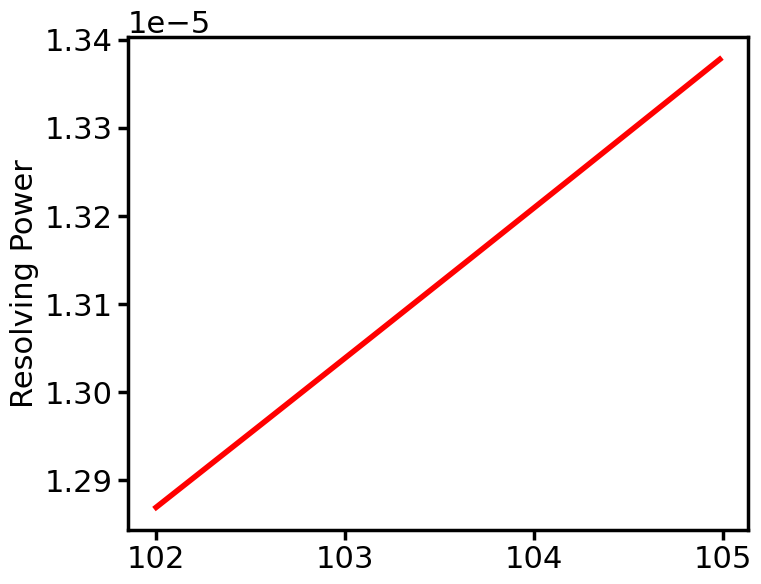

In [5]:
wave=np.arange(200)/200*3+102
set_rcparams_prop(amp=1.25)

rr=0.8
fig = plt.figure(figsize=(10*rr, 8*rr))
ax=fig.add_subplot(1,1,1, zorder=0)

lw=4
lsyts=['-','-','-','-']
clrs=['r','g','b','k']
fxs=(np.arange(4)*150-225)/3600
# fxs=(np.arange(4)*60-90)/3600
fxs=(np.arange(1)*60-30)/3600
fl=160
pscale=(fl*1000/(180*3600/np.pi))
dispersion=0.00148888*140/(300-fl)
print(pscale, dispersion)
skind='spat'
skind='spec'
cwave='1034'
# cwave='1040'
# aper='a5050'
# aper='a4040'
# aper='ap4060'
# aper='a4060'
aper='ap4050'
aper='app4050'
# aper='a4050'
# fys=np.ones(4)*(0/2/60)
fys=np.ones(4)*(30/2/60)
# 0.78,0.001488
for i in range(len(fxs)):
#     print('aa',i)
    lb=str(fxs[i])+'  '+str(fys[i])
    val=return_data(skind,cwave,aper,wave, fxs[i], fys[i], pscale, dispersion)
    ax.plot(wave, val, linestyle=lsyts[i],color=clrs[i],lw=lw, label=lb, zorder=1)

if skind=='spat':
    ax.set_ylabel('Spatial resolution')
if skind=='spec':
    ax.set_ylabel('Resolving Power')
plot_dlimit(ax, skind,cwave,aper, wave, fxs[i], fys[i], pscale, dispersion)

    
fl=225
fl=160
# fl=140
cwave='1034'
pscale=(fl*1000/(180*3600/np.pi))
dispersion=0.00148888*140/(300-fl)
aper='c4050'
aper='ap4060'
aper='ap4050'
aper='app4050'
# aper='a4040'
lsyts=['--','--','--','--']
for i in range(len(fxs)):
#     print('aa',i)
    lb=str(fxs[i])+'  '+str(fys[i])
    val=return_data(skind,cwave,aper,wave, fxs[i], fys[i], pscale, dispersion)
#     ax.plot(wave, val, linestyle=lsyts[i],color=clrs[i],lw=lw, label=lb, zorder=1)
    
# ax.axhline(35)
# plot_dlimit(ax, skind,cwave,aper, wave, fxs[i], fys[i], pscale, dispersion)


In [6]:
def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.

    Number of output dimensions must match number of input dimensions and 
        new axes must divide old ones.

    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)

    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]

    """
    operation = operation.lower()
    if not operation in ['sum', 'mean']:
        raise ValueError("Operation not supported.")
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                  ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        op = getattr(ndarray, operation)
        ndarray = op(-1*(i+1))
    return ndarray

m = np.arange(0,72,1).reshape((6,12))
n = bin_ndarray(m, new_shape=(3,12), operation='sum')
print(m)
print(n)

[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [12 13 14 15 16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31 32 33 34 35]
 [36 37 38 39 40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69 70 71]]
[[ 12  14  16  18  20  22  24  26  28  30  32  34]
 [ 60  62  64  66  68  70  72  74  76  78  80  82]
 [108 110 112 114 116 118 120 122 124 126 128 130]]


In [7]:
def congrid(a, newdims, method='linear', centre=False, minusone=False):
    '''Arbitrary resampling of source array to new dimension sizes.
    Currently only supports maintaining the same number of dimensions.
    To use 1-D arrays, first promote them to shape (x,1).
    
    Uses the same parameters and creates the same co-ordinate lookup points
    as IDL''s congrid routine, which apparently originally came from a VAX/VMS
    routine of the same name.

    method:
    neighbour - closest value from original data
    nearest and linear - uses n x 1-D interpolations using
                         scipy.interpolate.interp1d
    (see Numerical Recipes for validity of use of n 1-D interpolations)
    spline - uses ndimage.map_coordinates

    centre:
    True - interpolation points are at the centres of the bins
    False - points are at the front edge of the bin

    minusone:
    For example- inarray.shape = (i,j) & new dimensions = (x,y)
    False - inarray is resampled by factors of (i/x) * (j/y)
    True - inarray is resampled by(i-1)/(x-1) * (j-1)/(y-1)
    This prevents extrapolation one element beyond bounds of input array.
    '''
    if not a.dtype in [np.float64, np.float32]:
        a = np.cast[float](a)

    m1 = np.cast[int](minusone)
    ofs = np.cast[int](centre) * 0.5
    old = np.array( a.shape )
    ndims = len( a.shape )
    if len( newdims ) != ndims:
        print('dimension error')
#         print "[congrid] dimensions error. " 
#               "This routine currently only support " \
#               "rebinning to the same number of dimensions."
        return None
    newdims = np.asarray( newdims, dtype=float )
    dimlist = []

    if method == 'neighbour':
        for i in range( ndims ):
            base = np.indices(newdims)[i]
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        cd = np.array( dimlist ).round().astype(int)
        newa = a[list( cd )]
        return newa

    elif method in ['nearest','linear']:
        # calculate new dims
        for i in range( ndims ):
            base = np.arange( newdims[i] )
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        # specify old dims
        olddims = [np.arange(i, dtype = float) for i in list( a.shape )]

        # first interpolation - for ndims = any
        mint = scipy.interpolate.interp1d( olddims[-1], a, kind=method, fill_value='extrapolate' )
#         print('olddims', olddims[-1])
#         print('dimlist', dimlist[-1])
#         mint = interp1d( olddims[-1], a, kind=method )
#             itpfunc=interp1d(rdclass.wave, rdclass.value, 
#                                        kind=itpkind, fill_value=itpfillvalue)
        newa = mint( dimlist[-1] )

#         print('trorder', ndims-1)
#         print('newa shape', newa.shape)
#         trorder = [ndims - 1] + range( ndims - 1 )
        trorder = [ndims - 1].append(range( ndims - 1 ))
#         print('tr', trorder)
        for i in range( ndims - 2, -1, -1 ):
#             newa = newa.transpose( trorder )
            newa = np.transpose(newa, axes=trorder)

            mint = scipy.interpolate.interp1d( olddims[i], newa, kind=method, fill_value='extrapolate' )
            newa = mint( dimlist[i] )

        if ndims > 1:
            # need one more transpose to return to original dimensions
            newa = newa.transpose( trorder )

        return newa
    elif method in ['spline']:
        oslices = [ slice(0,j) for j in old ]
        oldcoords = np.ogrid[oslices]
        nslices = [ slice(0,j) for j in list(newdims) ]
        newcoords = np.mgrid[nslices]

        newcoords_dims = range(np.rank(newcoords))
        #make first index last
        newcoords_dims.append(newcoords_dims.pop(0))
        newcoords_tr = newcoords.transpose(newcoords_dims)
        # makes a view that affects newcoords

        newcoords_tr += ofs

        deltas = (np.asarray(old) - m1) / (newdims - m1)
        newcoords_tr *= deltas

        newcoords_tr -= ofs

        newa = scipy.ndimage.map_coordinates(a, newcoords)
        return newa
    else:
        print('congrid error unrecognized interpolation type')
#         print "Congrid error: Unrecognized interpolation type.\n", \
#               "Currently only \'neighbour\', \'nearest\',\'linear\',", \
#               "and \'spline\' are supported."
        return None

In [8]:
def psf_gaussian(npixel=0, ndimension=2, fwhm=0, st_dev=0, normalize=True):
    sigma=fwhm/(2*(2*np.log(2))**(0.5))
    if st_dev != 0:
        sigma=st_dev
    
    if ndimension == 1:
        cntrd=np.array([(npixel-1)/2])
        x= np.arange(npixel)-cntrd[0]
        mu=0        
        psf= np.exp(-( 0.5*(x-mu)**2 / ( sigma**2 ) ) )
        return (psf/np.sum(psf)).astype('float64')
    if ndimension == 2:
        cntrd=np.array([(npixel-1)/2., (npixel-1)/2.])
        x, y = np.meshgrid(np.arange(npixel)-cntrd[0], np.arange(npixel)-cntrd[1], sparse=False)
        d = np.sqrt(x*x+y*y)
        mu=0
        psf= np.exp(-( 0.5*(d-mu)**2 / ( sigma**2 ) ) )
        return (psf/np.sum(psf)).astype('float64')
# gauss=psf_gaussian(npixel=11, ndimension=2, fwhm=2)
# gauss=psf_gaussian(npixel=111, ndimension=1, fwhm=20)

# plt.plot(np.arange(111), gauss, 'ko')
# plt.imshow(gauss, cmap=cm.YlGnBu_r, origin='lower', interpolation='none')
# print(gauss)

def put_value_image(img, value, cx, cy, xw, yw, subarcsec):
    px_i=int(img.shape[1]/2+(cx-xw/2)/subarcsec)
    px_e=int(img.shape[1]/2+(cx+xw/2)/subarcsec)
    
    py_i=int(img.shape[0]/2+(cy-yw/2)/subarcsec)
    py_e=int(img.shape[0]/2+(cy+yw/2)/subarcsec)
    
    meanval=np.mean(img[py_i:py_e,px_i:px_e])
    img[py_i:py_e,px_i:px_e]=value
    return img, meanval



def return_psf_fwhm(cwave,aper, wave, fx, fys, tail='slit'):
    cdir='./macro_result'
#     fname='_'.join([skind,'c'+cwave,''+aper])
    fname='aspera_xenc_spatial_fwhm_'+tail
    data_file=cdir+'/'+fname+'.txt'
#     print(cat_str)

    datacol=1
    skiprows=0

    data=np.loadtxt(data_file, usecols=(0,1,2,3), dtype=float,
                    skiprows=skiprows)
    print(data[0,3])
    wtol=0.01
    ftol=1/3600
    cond=(np.abs(data[:,0]-wave) < wtol) & (np.abs(data[:,1]-fx) < ftol)
    
    itpfy=(data[:,2])[cond]
    itpvals=(data[:,3])[cond]/2
    
    sortidx=np.argsort(itpfy)
    itpfunc=interp(itpfy[sortidx], itpvals[sortidx],fys)
#     print(data[:,1])
#     print(itpfunc(wave))
    return itpfy[sortidx], itpvals[sortidx], itpfunc
#     if skind=='spat':
#         return(itpfunc(wave)*2/pscale)
#     if skind=='spec':
#         return(wave/(2*itpfunc(wave)*dispersion))

In [9]:


def convolve_psf(imgin, ptoa, pscale, fwhm_func, fwhm_to_size, axis=0):
    sig2fwhm=2*(2*np.log(2))**0.5
    oarr=np.zeros_like(imgin)
    zarr=np.zeros_like(imgin)
    
#     dist=zarr+np.abs(np.arange(imgin.size).reshape(imgin.shape[0],imgin.shape[1])//imgin.shape[1]-ny//2)*ptoa
    
#     print(imgin.shape, ydist.shape)
#     if axis==1:
    im_axis_in_arcsec=np.abs((np.arange(imgin.shape[axis])-imgin.shape[axis]//2)*ptoa)
#     print('aa', len(im_axis_in_arcsec))
    
#     im_y_in_arcsec=np.abs((np.arange(ny)-ny//2)*ptoa)
#     unique_im_y=np.unique(im_y_in_arcsec)
#     print('n unique', len(unique_im_y))
#     print(list(im_y_in_arcsec))
#     for i in range(len(unique_im_y)):
    npix_axis=imgin.shape[axis]
    print('npix_axis', npix_axis)
    
    for i in range(npix_axis):
#     for i in [600]:
#         print(ydist)
#         cond=(ydist==unique_im_y[i])
#         print(np.sum(cond))
        conv_bf_arr=zarr.copy()
#         print(imgin.shape, conv_bf_arr.shape)
        if axis==0:
#             conv_bf_arr[i,:]=imgin[i,:]
            conv_bf_arr=imgin[i,:]
        if axis==1:
#             conv_bf_arr[:,i]=imgin[:,i]
            conv_bf_arr=imgin[:,i]
#         print(list(imgin[cond]))
        
        conv_fwhm=fwhm_func(im_axis_in_arcsec[i]/3600)*2/pscale/ptoa
#         print(conv_fwhm)
#         psf_arr_size=conv_fwhm*fwhm_to_size
        psf_arr_size=(np.clip(conv_fwhm*fwhm_to_size,10,None) // 2)*2+1
#         psf_gauss=psf_gaussian(npixel=psf_arr_size, ndimension=2, fwhm=conv_fwhm, normalize=True)
        psf_gauss=psf_gaussian(npixel=psf_arr_size, ndimension=1, fwhm=conv_fwhm, normalize=True)
        
        if axis==0:
            oarr[i,:]=convolve(conv_bf_arr,psf_gauss,mode='same')
        if axis==1:
            oarr[:,i]=convolve(conv_bf_arr,psf_gauss,mode='same')
    return oarr
    


def convolve_psf_oneslit(imgin, pi, slitw, ptoa, pscale, fwhm_func_image, fwhm_to_size, axis=0):
    #pi and slitw in pixel unit
    sig2fwhm=2*(2*np.log(2))**0.5
    if axis==0:
        oarr=np.zeros((imgin.shape[axis],int(slitw*4)))
    if axis==1:
        oarr=np.zeros((int(slitw*4),imgin.shape[axis]))
    zarr=np.zeros_like(oarr)
    sarr=np.zeros_like(oarr)
    nx=zarr.shape[1]
    ny=zarr.shape[0]
    
    if axis==0:
        sarr[:,(nx//2-slitw//2):(nx//2-slitw//2+slitw)]=imgin[:,pi:(pi+slitw)]
    if axis==1:
#         print('inarr shape',imgin.shape, (imgin.T).shape)
#         timgin=imgin.T
#         print('pi, slitw',pi, slitw)
        sarr[(ny//2-slitw//2):(ny//2-slitw//2+slitw),:]=imgin[pi:(pi+slitw),:]
#     (imgin[pi:(pi+slitw),:]).T
        
    im_axis_in_arcsec=np.abs((np.arange(imgin.shape[axis])-imgin.shape[axis]//2)*ptoa)
#     print('aa', len(im_axis_in_arcsec))
    
#     im_y_in_arcsec=np.abs((np.arange(ny)-ny//2)*ptoa)
#     unique_im_y=np.unique(im_y_in_arcsec)
#     print('n unique', len(unique_im_y))
#     print(list(im_y_in_arcsec))
#     for i in range(len(unique_im_y)):
    npix_axis=imgin.shape[axis]
#     print('npix_axis, start')
    for i in range(npix_axis):
        conv_bf_arr=zarr.copy()
        if axis==0:
            conv_bf_arr[i,:]=sarr[i,:]
        if axis==1:
            conv_bf_arr[:,i]=sarr[:,i]
            
#         fwhm_slit=fwhm_func_slit(im_axis_in_arcsec[i]/3600)*2/pscale/ptoa
#         fwhm_image=fwhm_func_image(im_axis_in_arcsec[i]/3600)*2/pscale/ptoa
#         conv_fwhm=(fwhm_image**2-fwhm_slit**2)**0.5
        conv_fwhm=fwhm_func_image(im_axis_in_arcsec[i]/3600)*2/pscale/ptoa
#         print(i, conv_fwhm)
        psf_arr_size=(np.clip(conv_fwhm*fwhm_to_size,10,None) // 2)*2+1
        psf_gauss=psf_gaussian(npixel=psf_arr_size, ndimension=2, fwhm=conv_fwhm, normalize=True)
        oarr=oarr+convolve2d(conv_bf_arr,psf_gauss,mode='same')
#     return oarr.sum(axis=1)
    if axis==0:
        return oarr.sum(axis=1)
    if axis==1:
        return oarr.sum(axis=0)

def convolve_psf_comb(imgin, pi_arcsec, slitw_arcsec, ptoa, pscale, 
                      fwhm_func_image, fwhm_to_size, axis=0, select_slit=[],
                      exparr=np.array([3*24*3600]), effarea=4*5*0.75**3*0.45*0.4):
    npix_cross_slit=imgin.shape[int((axis==0)*1+(axis==1)*0)]
    slitw_pix=int(slitw_arcsec/ptoa)
    pi_pix=int(pi_arcsec/ptoa)
    nslit=npix_cross_slit//slitw_pix
    if axis==0:
        outarr=np.zeros((imgin.shape[axis],nslit))
    if axis==1:
        outarr=np.zeros((nslit,imgin.shape[axis]))
    if len(exparr)==1:
        exparr=np.ones(nslit)*exparr[0]
    print('nslit:', nslit)
    
#     for i in [12,24]:
    if len(select_slit)==0:
        range_arr=range(nslit)
    else:
        range_arr=select_slit
    for i in range_arr:
        if (i%5)==0:
            print(i)
        if axis==0:
            outarr[:,i]=convolve_psf_oneslit(imgin, pi_pix+slitw_pix*i, slitw_pix, ptoa, pscale, fwhm_func_image, 
                                     fwhm_to_size, axis=axis)*exparr[i]
        if axis==1:
#             print('outarr shape', (outarr[i,:]).shape)
            outarr[i,:]=convolve_psf_oneslit(imgin, pi_pix+slitw_pix*i, slitw_pix, ptoa, pscale, fwhm_func_image, 
                                     fwhm_to_size, axis=axis)*exparr[i]
    pixel_sqarcsec=slitw_arcsec*ptoa
#     outarr=outarr*effarea*pixel_sqarcsec
#     mcp_bg_rate_pix=(slitw_pix*pi_pix)*(ptoa*pscale)**2/(1000*10)**2
    outarr=outarr*effarea*pixel_sqarcsec
    return outarr
#     if axis==0:
#         return outarr
#     if axis==1:
#         return outarr.T


def rebin_slit_direction(cross_slit_arr, spatialbin_arcsec, binoff_arcsec, ptoa, pscale, axis=0):
    spatialbin_pix=int(spatialbin_arcsec/ptoa)
    binoff_pix=int(binoff_arcsec/ptoa)
    npix_spatial=(cross_slit_arr.shape[axis]//spatialbin_pix)
    print('ori n spatial bin',cross_slit_arr.shape[axis])
    print('spatialbin_pix, binoff_pix, npix_spatial', spatialbin_pix, binoff_pix, npix_spatial)
    
    if axis==0:
        arr_crop=cross_slit_arr[binoff_pix:(binoff_pix+npix_spatial*spatialbin_pix),:]
        new_shape=(npix_spatial, cross_slit_arr.shape[1])
    if axis==1:
        arr_crop=cross_slit_arr[:,binoff_pix:(binoff_pix+npix_spatial*spatialbin_pix)]
        new_shape=(cross_slit_arr.shape[0],npix_spatial)
    print('arr crop shape', arr_crop.shape)
    

    
    print('new shape', new_shape)
    farr=bin_ndarray(arr_crop, new_shape, operation='sum')
    return farr
#     if axis==0:
#         return farr
#     if axis==1:
#         return farr.T

def bg_noise(rebin_arr, mcp_bg, pscale, spatialbin_arcsec, dispersion, spec_window, exparr, 
                 axis=1, select_slit=[]):
#     mcp_bg_rate_pix=mcp_bg*(spatialbin_arcsec*pscale)*(spec_window/(dispersion*10)*1000)/(1000*10)**2
    mcp_bg_rate_pix=mcp_bg
#     print('spec bin', (spec_window/(dispersion*10)*1000), mcp_bg, (spatialbin_arcsec*pscale))
#     print( (spec_window/(dispersion*10)*1000)*mcp_bg*(spatialbin_arcsec*pscale)*24*3600*4/ (1000*10)**2)
    noise_count_arr=np.zeros(rebin_arr.shape)
    nslit=comb_arr.shape[(axis==0)*1+(axis==1)*0]
    if len(select_slit)==0:
        range_arr=range(nslit)
    else:
        range_arr=select_slit
    
    for i in range_arr:
        if axis==0:
            noise_count_arr[:,i]=noise_count_arr[:,i]+mcp_bg_rate_pix*exparr[i]            
        if axis==1:
            noise_count_arr[i,:]=noise_count_arr[i,:]+mcp_bg_rate_pix*exparr[i]
#         print('bg added: ',mcp_bg_rate_pix*exparr[i])
#     noise_added_arr=comb_arr+noise_count_arr
    return noise_count_arr
    
# noise_arr=bg_noise(rebin_arr, mcp_bg, pscale, spatialbin_arcsec, dispersion, spec_window, exparr, 
#                  axis=saxis, select_slit=select_slit)
# print(rebin_arr.shape, noise_arr.shape)

In [10]:
fname='edgeon_Ryan_z0_Emission_OVI_1032_270kpc.fits'
tt=fits.open(fname)
oim=np.transpose(tt['PRIMARY'].data, axes=(1,0))
# oim=tt['PRIMARY'].data

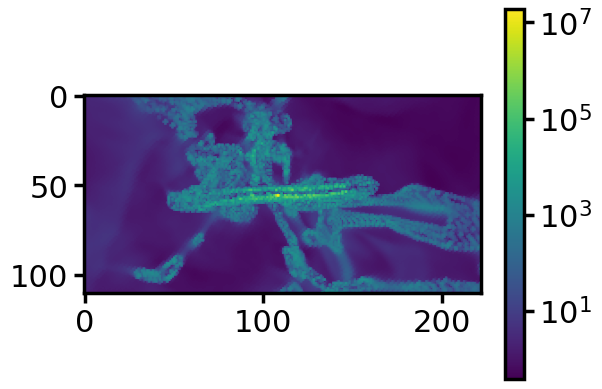

In [11]:
plt.imshow(oim, norm = LogNorm())
plt.colorbar()

In [12]:
def photon_energy(lam=103.5): # lambda in nanometer
    return constants.h/1e-7*constants.c/(lam*1e-9)

5.689759413
6.411785865


Text(0, 0.5, 'image')

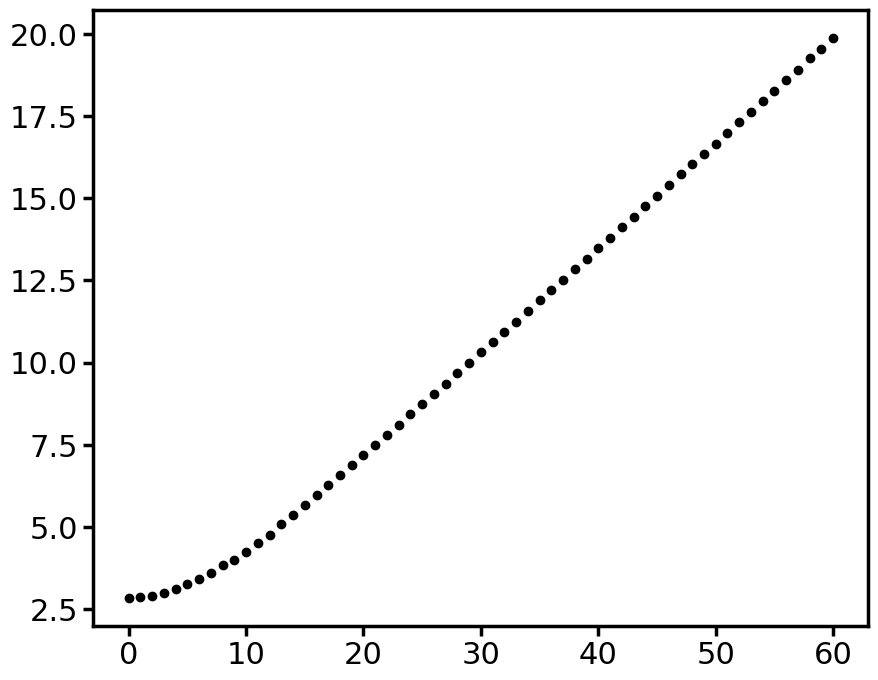

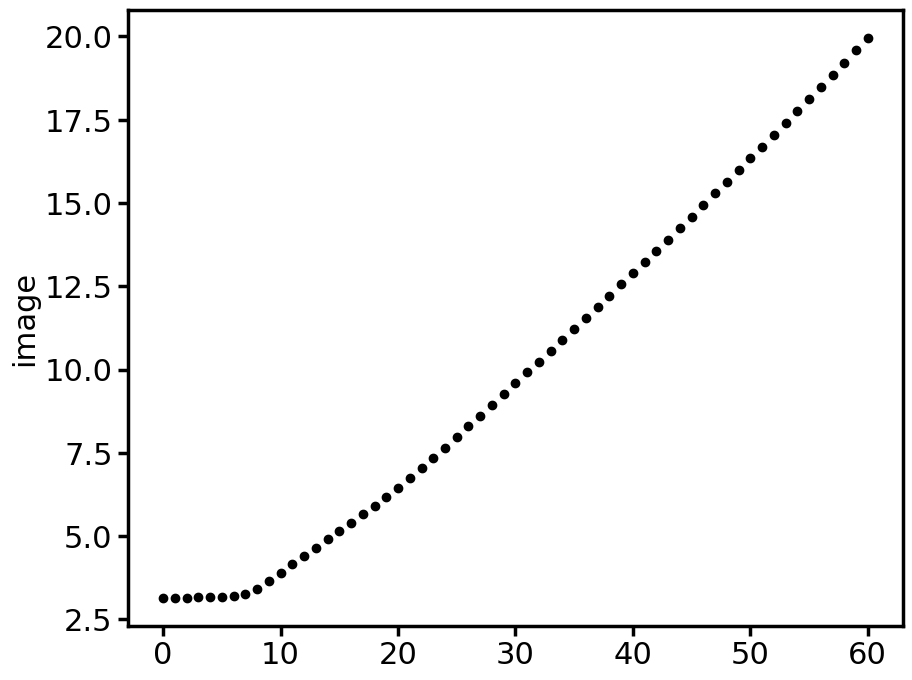

In [13]:
skind='spat'
cwave='1034'
aper='ap4050'
nfys=np.arange(20)/20*45/3600/2
fx=-225/3600
fw=1035
fys, fwhms, fwhm_func_slit=return_psf_fwhm(cwave,aper, fw, fx, nfys, tail='slit')

fys2, fwhms2, fwhm_func_image=return_psf_fwhm(cwave,aper, fw, fx, nfys, tail='image')

rr=1
fig = plt.figure(figsize=(10*rr, 8*rr))
ax=fig.add_subplot(1,1,1, zorder=0)
# ax.plot(fys,fwhms, 'ko')
ax.plot(fys*60,fwhms, 'ko')

fig2 = plt.figure(figsize=(10*rr, 8*rr))
ax2=fig2.add_subplot(1,1,1, zorder=0)
# ax.plot(fys,fwhms, 'ko')
# ax2.plot(fys2*60,fwhms2-fwhms, 'ko')
ax2.plot(fys2*60,fwhms2, 'ko')
ax2.set_ylabel('image')

In [14]:
rtoa=180*3600/np.pi
perg=photon_energy(103.5)
psr2psqarc=1/rtoa**2
sig2fwhm=2*(2*np.log(2))**0.5
pscale=160*1000/rtoa
cim=oim.copy()/rtoa**2   #convert unit of image from 'count/s/cm2/sr' to 'count/s/cm2/arcsec2'
# subarcsec=1.25   #0.5 take too long time for convolution. 1.25 is appropriate
# subarcsec=2.5   #0.5 take too long time for convolution. 1.25 is appropriate
subarcsec=7.5   #0.5 take too long time for convolution. 1.25 is appropriate
img_height_in_kpc=30
# dist=1.05/(30/rtoa) #Mpc
dist=7.35 #Mpc, NED, 2013AJ 146 85 TRGB
img_height_in_arcsec=img_height_in_kpc/(dist*1000)*rtoa
print('height in arcsec', img_height_in_arcsec)
npix_height=int(np.round(img_height_in_arcsec/subarcsec))
npix_width=npix_height*2
# npix_width=int(np.round(img_height_in_arcsec/cim.shape[0]*cim.shape[1]/subarcsec))
print('New number of height and width pixels', npix_height, npix_width)
newdims=[npix_height, npix_width]

im=congrid(cim, newdims, method='linear')   #project to new grid


height in arcsec 841.8971683554954
New number of height and width pixels 112 224


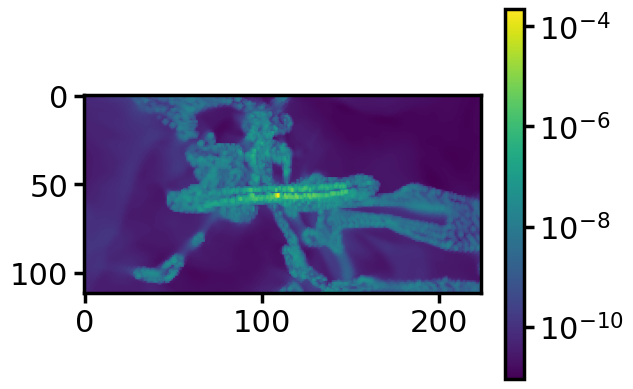

In [15]:
plt.imshow(im, norm=LogNorm())
plt.colorbar()

In [16]:

cnt_ori=cim*(img_height_in_arcsec/oim.shape[0])**2
cnt_after=im*(subarcsec)**2
 #sanity check: make sure total count is reserved
print('Sanity Check (should be 1)',np.sum(cnt_ori)/np.sum(cnt_after)) 

ptoa=subarcsec

# sc_jitter=8 #arcsec, 1-sigma
# sc_jitter=(7.2**2+1+0*(15/2*1.29)**2)**0.5 #arcsec, 1-sigma  + thermal
sc_jitter=(7.2**2+1+(10/2*1.29)**2)**0.5 #arcsec, 1-sigma  + thermal
sc_jitter=(3.6**2+1+(10/2*1.29)**2)**0.5 #arcsec, 1-sigma  + thermal #improved
sc_jitter=2
# sc_jitter=(8**2+30**2)**0.5 #arcsec, 1-sigma  + thermal
npix_sc_jitter_fwhm=sc_jitter/ptoa*2.355
fwhm_to_size=3
psf_arr_size=npix_sc_jitter_fwhm*fwhm_to_size
psf_gauss=psf_gaussian(npixel=psf_arr_size, ndimension=2, fwhm=npix_sc_jitter_fwhm, normalize=True)

oamp=1
im_scjitter=convolve2d(im*oamp,psf_gauss,mode='same')
#fff

Sanity Check (should be 1) 1.004638093060179


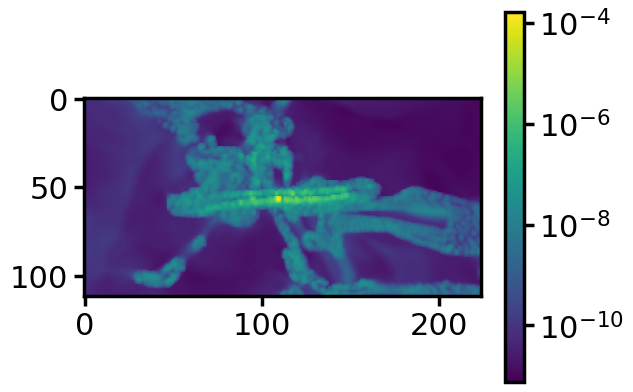

In [17]:
plt.imshow(im_scjitter, norm = LogNorm())
plt.colorbar()

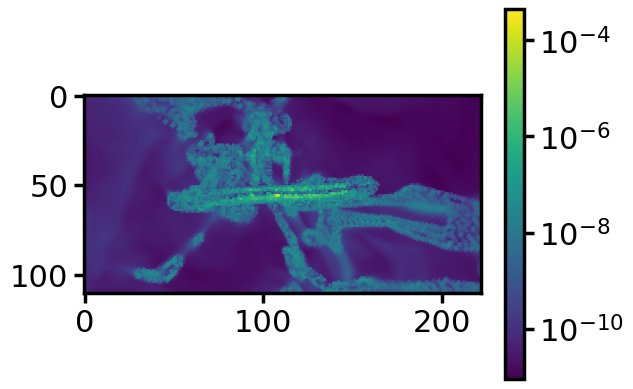

In [18]:
plt.imshow(cim, norm=LogNorm())
plt.colorbar()

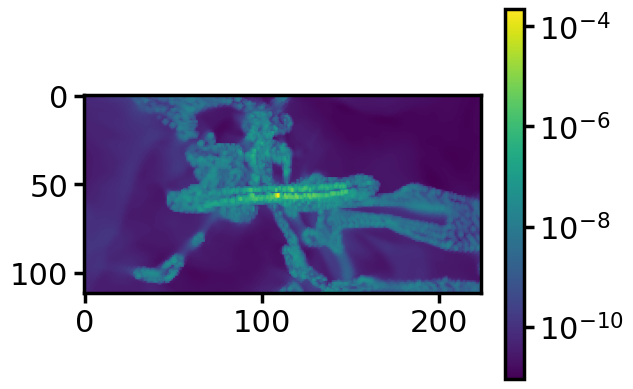

In [19]:
plt.imshow(im, norm=LogNorm())
plt.colorbar()

mean_flux 5.747071978273692e-19
norm_factor 0.905913346140671


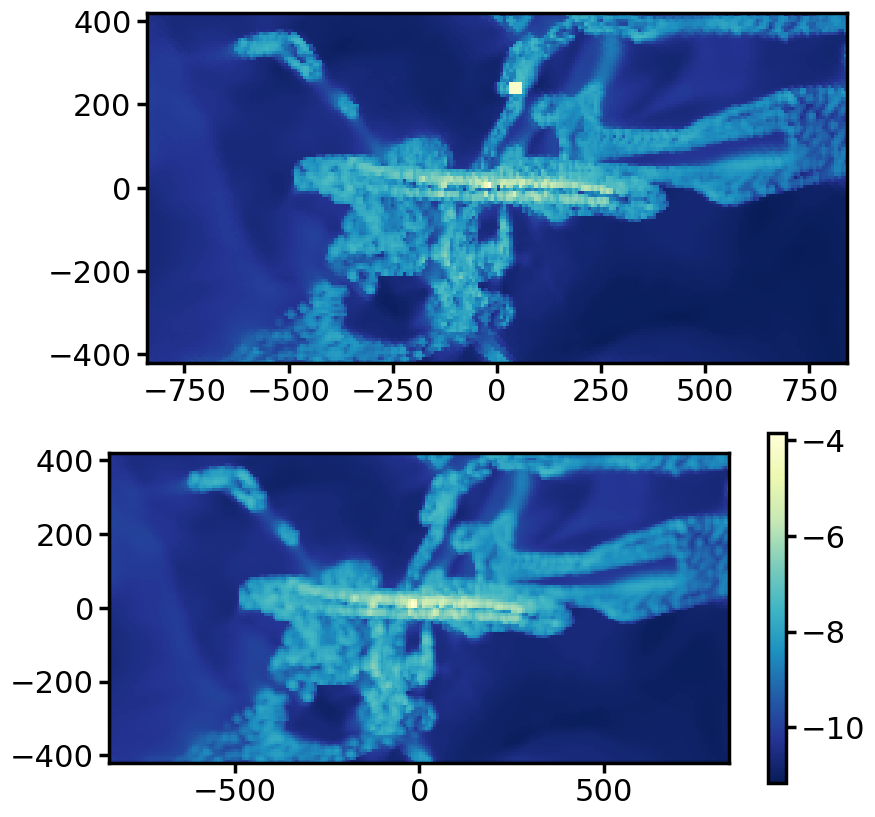

In [20]:
rr=1
fig = plt.figure(figsize=(10*rr, 10*rr))
ax=fig.add_subplot(2,1,1, zorder=0)
ax2=fig.add_subplot(2,1,2, zorder=0)
    

# im=np.log10(oim)
# im[80,34:41]=7
dx=subarcsec
dy=dx
x_center = im.shape[1]//2
y_center = im.shape[0]//2
x_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - x_center)) * dx
y_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - y_center)) * dy

extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]
ovi_extent=extent.copy()

# pa=(0.4,2.5)
# cx, cy=0.4*60, 2.5*60
cx, cy=0.8*60, 4*60

cx, cy=1.1*60, 4.3*60    # before grating eff. degradation (60%)
cx, cy=0.8*60, 4.1*60    # after grating eff. degradation (60%)
# cx, cy=-1.45*60, -2.5*60
cw=30
# cw=60
# cx, cy=45, 240
# cw=30

# cx, cy=0, 0

value=1e-4
show_im, mean_flux=put_value_image(im.copy(), value, cx, cy, cw,cw, subarcsec)
# show_im=im.copy()
# baseline_requirement=8.9e-19
# baseline_requirement=(1.64e-18)/43*55
baseline_requirement=(1.64e-18)/3600*8000
baseline_requirement=(1.64e-18)/3600*8000/5
baseline_requirement=(1.64e-18)/3600*8000/7
print('mean_flux',mean_flux*perg)
norm_factor=baseline_requirement/(mean_flux*perg)
print('norm_factor',norm_factor)

pim=im_scjitter*norm_factor

img=ax.imshow(np.log10(show_im), extent=extent, cmap=cm.YlGnBu_r, 
                  origin='lower', interpolation='none')
# plt.colorbar(img)

img2=ax2.imshow(np.log10(pim), extent=extent, 
#                 cmap=cm.hsv, 
                cmap=cm.YlGnBu_r, 
                  origin='lower', interpolation='none')
plt.colorbar(img2)
#fff

In [21]:
def convolve_ydep_test(imgin, ptoa, pscale, fwhm_func, fwhm_to_size, axis=0):
    sig2fwhm=2*(2*np.log(2))**0.5
    oarr=np.zeros_like(imgin)
    zarr=np.zeros_like(imgin)
    ny=imgin.shape[0]

    im_axis_in_arcsec=np.abs((np.arange(imgin.shape[axis])-imgin.shape[axis]//2)*ptoa)
    print('aa', len(im_axis_in_arcsec))

    npix_axis=imgin.shape[axis]

    for i in [50]:

        conv_bf_arr=zarr.copy()
        if axis==0:
            conv_bf_arr[i,:]=imgin[i,:]
        if axis==1:
            conv_bf_arr[:,i]=imgin[:,i]
        
        conv_fwhm=fwhm_func(im_axis_in_arcsec[i]/3600)*2/pscale/ptoa
        psf_arr_size=conv_fwhm*fwhm_to_size
        psf_gauss=psf_gaussian(npixel=psf_arr_size, ndimension=2, fwhm=conv_fwhm, normalize=True)
        
        oarr=oarr+convolve2d(conv_bf_arr,psf_gauss,mode='same')
    return conv_bf_arr, oarr

aa 112


/tmp/ipykernel_690030/1847339451.py:7: RuntimeWarning: divide by zero encountered in log10
  img=ax.imshow(np.log10(bf), extent=extent, cmap=cm.YlGnBu_r,
/tmp/ipykernel_690030/1847339451.py:10: RuntimeWarning: divide by zero encountered in log10
  img2=ax2.imshow(np.log10(af), extent=extent, cmap=cm.YlGnBu_r,


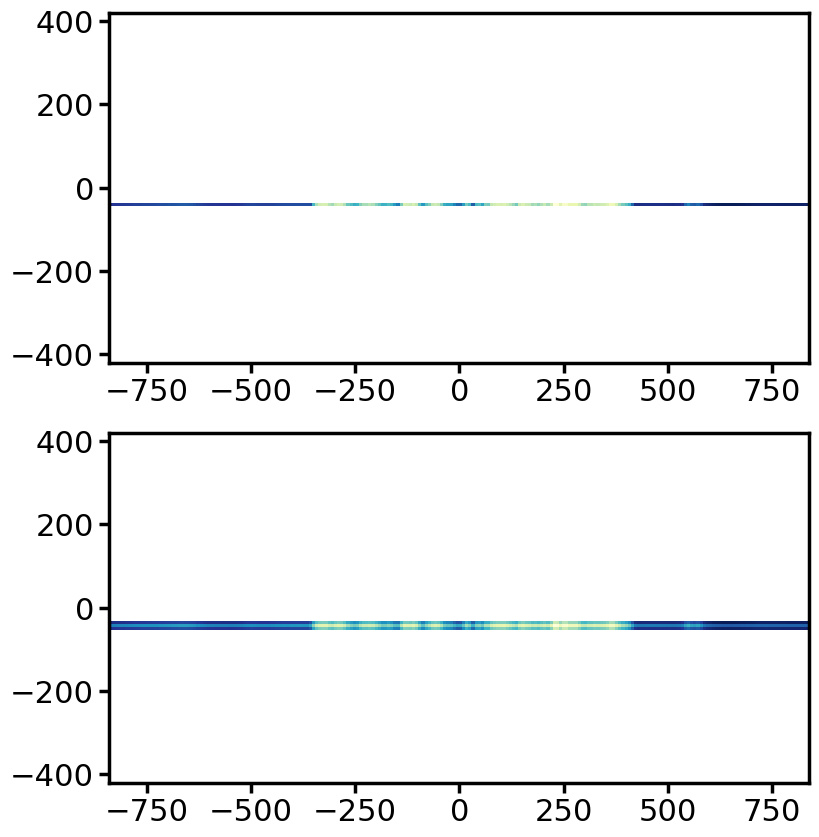

In [22]:
fig = plt.figure(figsize=(10*rr, 10*rr))
ax=fig.add_subplot(2,1,1, zorder=0)
ax2=fig.add_subplot(2,1,2, zorder=0)

bf,af=convolve_ydep_test(pim, ptoa, pscale, fwhm_func_slit, fwhm_to_size, axis=0)

img=ax.imshow(np.log10(bf), extent=extent, cmap=cm.YlGnBu_r, 
                  origin='lower', interpolation='none')

img2=ax2.imshow(np.log10(af), extent=extent, cmap=cm.YlGnBu_r, 
                  origin='lower', interpolation='none')

npix_axis 224


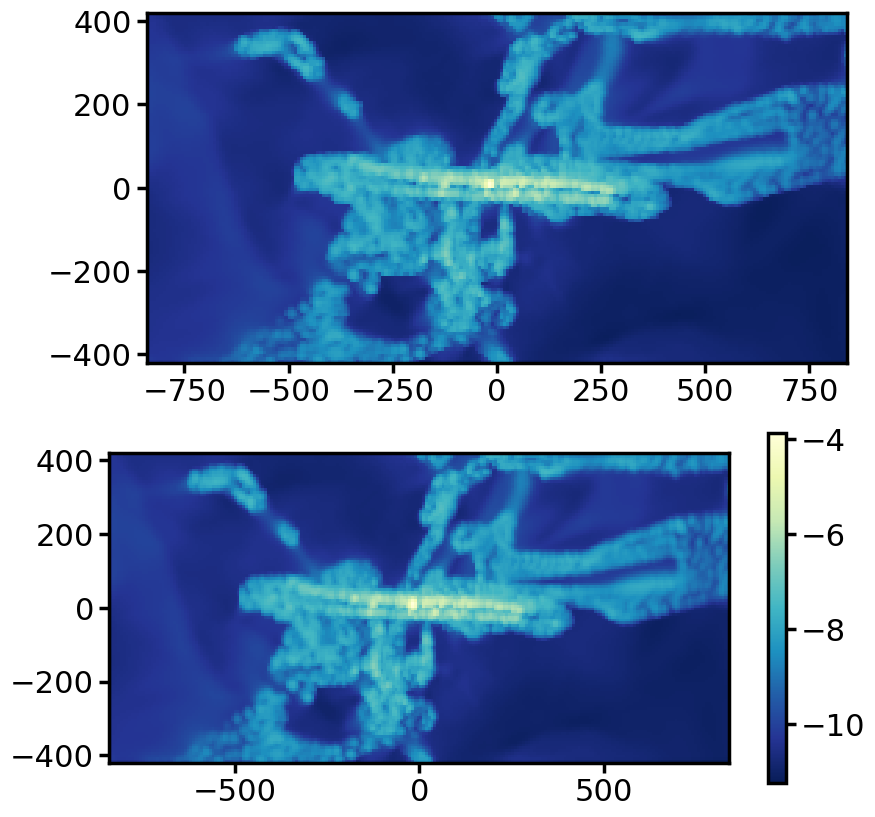

In [23]:
fig = plt.figure(figsize=(10*rr, 10*rr))
ax=fig.add_subplot(2,1,1, zorder=0)
ax2=fig.add_subplot(2,1,2, zorder=0)

saxis=1
pi_arcsec=2
slitw_arcsec=30
slitw_arcsec=15
im_slit_convolve=convolve_psf(pim, ptoa, pscale, fwhm_func_slit, fwhm_to_size, axis=saxis)

img=ax.imshow(np.log10(pim), extent=extent, cmap=cm.YlGnBu_r, 
                  origin='lower', interpolation='none')

img2=ax2.imshow(np.log10(im_slit_convolve), extent=extent, cmap=cm.YlGnBu_r, 
                  origin='lower', interpolation='none')
plt.colorbar(img2)

nslit aa 56
total exposure time (days): 29.166666666666668
nslit: 56
0
5
10
15
20
25
30
35
40
45
50
55
(56, 224)


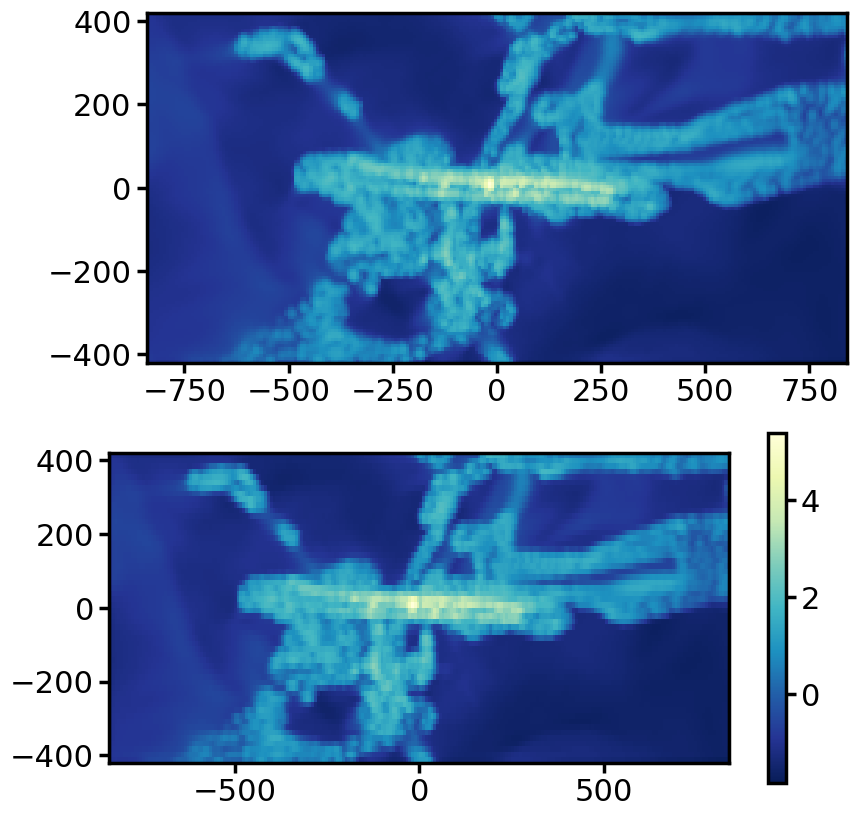

In [24]:
fig = plt.figure(figsize=(10*rr, 10*rr))
ax=fig.add_subplot(2,1,1, zorder=0)
ax2=fig.add_subplot(2,1,2, zorder=0)

npix_cross_slit=im_slit_convolve.shape[int((saxis==0)*1+(saxis==1)*0)]
slitw_pix=int(slitw_arcsec/ptoa)
pi_pix=int(pi_arcsec/ptoa)
nslit=npix_cross_slit//slitw_pix
print('nslit aa', nslit)
# exparr=np.ones(nslit)*4*24*3600
exparr=np.ones(nslit)*2*24*3600
exparr=np.ones(nslit)*10*3600*5
# exparr=np.ones(nslit)*1.5*24*3600
# exparr[[12,13,14,15]]=0.5*24*3600
totalexp=np.sum(exparr)
select_slit=[]
# select_slit=[14,16,18,20]
n_channel=4
print('total exposure time (days):', totalexp/24/3600/n_channel)
# mcp_bg=0.3
case=0
# case=1
# case=2
if case == 0:
    mcp_bg, effarea=0.001/3600*28, 60  #skipper
if case == 1:
    mcp_bg, effarea=0.001/3600*28+7/5000*0.5, 60  #emccd
if case == 2:
    mcp_bg, effarea=0.3/(1000*10)**2*48*84, 20  #mcp

pi_arcsec=2
# slitw_arcsec=30
slitw_arcsec=15
# slitw_arcsec=60
comb_arr=convolve_psf_comb(im_slit_convolve, pi_arcsec, slitw_arcsec, ptoa, pscale, 
                      fwhm_func_image, fwhm_to_size, axis=saxis, select_slit=select_slit,
                           exparr=exparr, effarea=effarea)

comb_arr_slit=comb_arr.copy()



print(comb_arr.shape)
img=ax.imshow(np.log10(im_slit_convolve), extent=extent, cmap=cm.YlGnBu_r, 
                  origin='lower', interpolation='none')

img2=ax2.imshow(np.log10(comb_arr), extent=extent, cmap=cm.YlGnBu_r, 
                  origin='lower', interpolation='none')
plt.colorbar(img2)


ori n spatial bin 224
spatialbin_pix, binoff_pix, npix_spatial 2 0 112
arr crop shape (56, 224)
new shape (56, 112)
7.777777777777777e-06 0.7757018897752576 15 15 11.635528346628863 11.635528346628863
(56, 112)


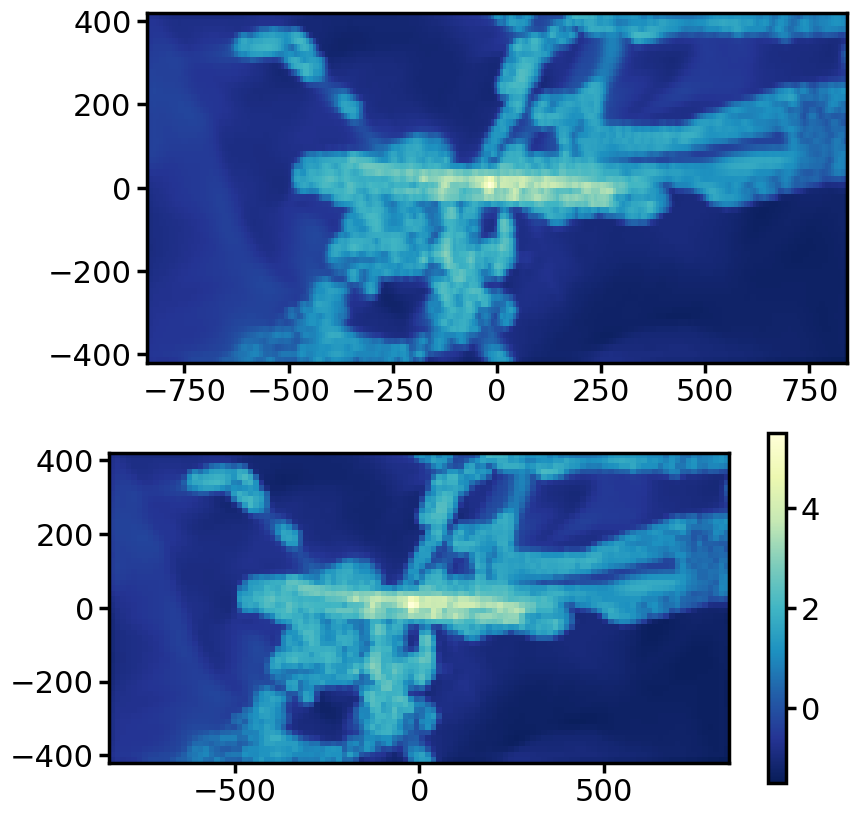

In [25]:
fig = plt.figure(figsize=(10*rr, 10*rr))
ax=fig.add_subplot(2,1,1, zorder=0)
ax2=fig.add_subplot(2,1,2, zorder=0)

spatialbin_arcsec=30
spatialbin_arcsec=15
# spatialbin_arcsec=22.5
binoff_arcsec=2
farr=rebin_slit_direction(comb_arr, spatialbin_arcsec, binoff_arcsec, ptoa, pscale, axis=saxis)

dispersion=1.489 #nm/mm
spec_window=1 #Angstrom
rseed=0
print(mcp_bg, pscale, spatialbin_arcsec, slitw_arcsec, pscale*spatialbin_arcsec,pscale*slitw_arcsec)
noise_count_arr=bg_noise(farr,mcp_bg, pscale, spatialbin_arcsec, dispersion, spec_window, exparr, 
                 axis=saxis, select_slit=select_slit)



print(farr.shape)
# print(np.sum(bf))
img=ax.imshow(np.log10(comb_arr), extent=extent, cmap=cm.YlGnBu_r, 
                  origin='lower', interpolation='none')

img2=ax2.imshow(np.log10(farr), extent=extent, cmap=cm.YlGnBu_r, 
                  origin='lower', interpolation='none')
plt.colorbar(img2)


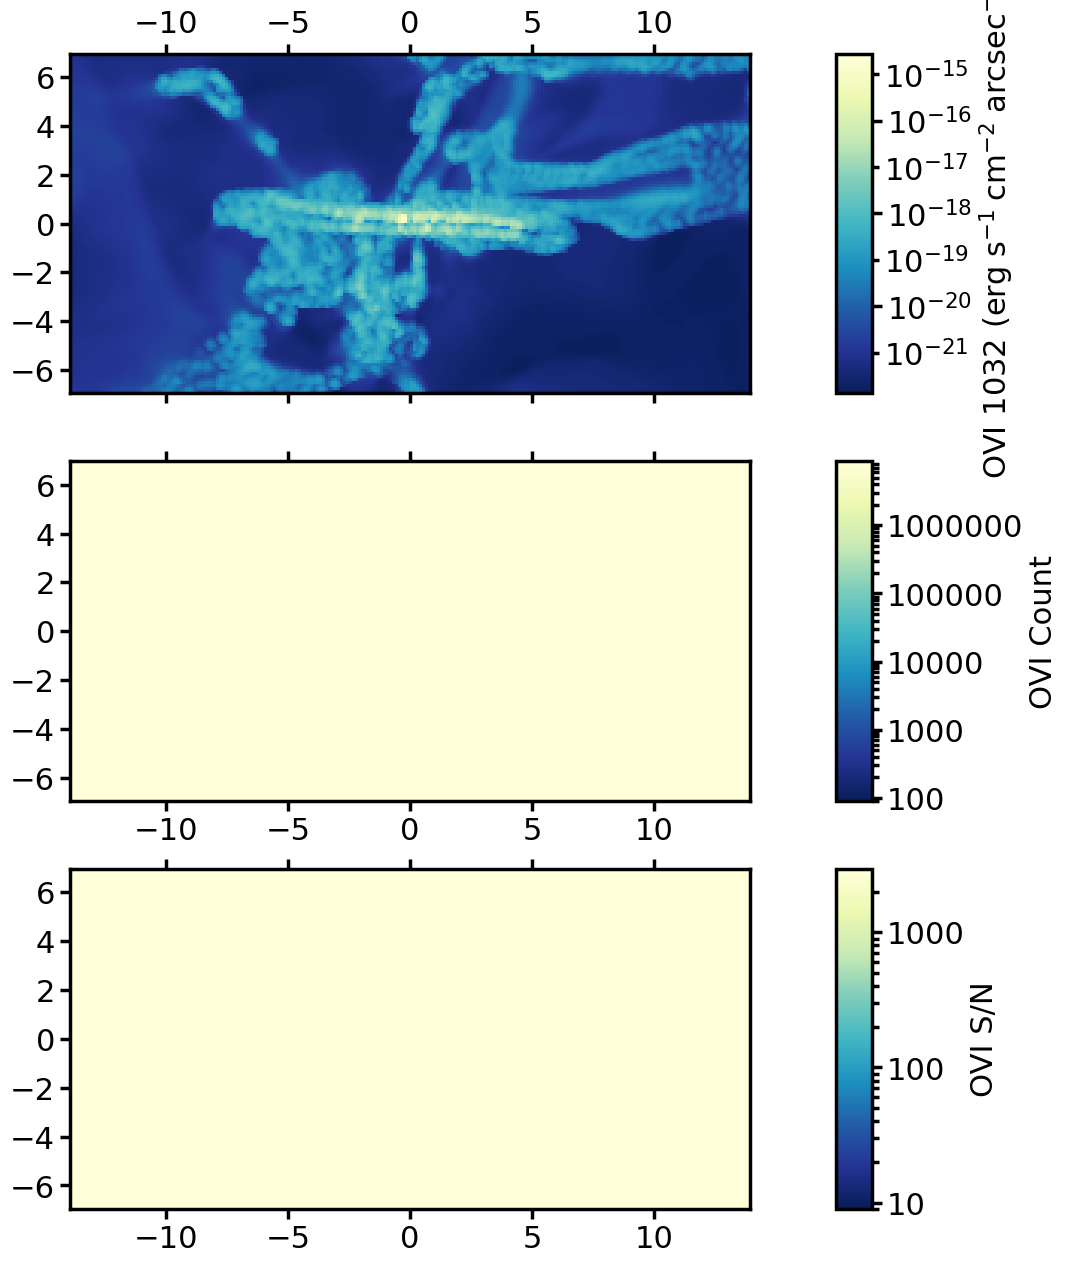

In [72]:
texp=3*24*3600
# texp=5*24*3600
effarea=4*5*0.75**3*0.45*0.4
# pixelsize_radian=mcppixel_size_micron/pscale/rtoa
pixelsize_sqarcsec=30*22.5
ovi_count_map_fine=farr*texp*effarea*pixelsize_sqarcsec
# ovi_count_map_fine=farr


NameError: name 'ovi_count_map_fine' is not defined

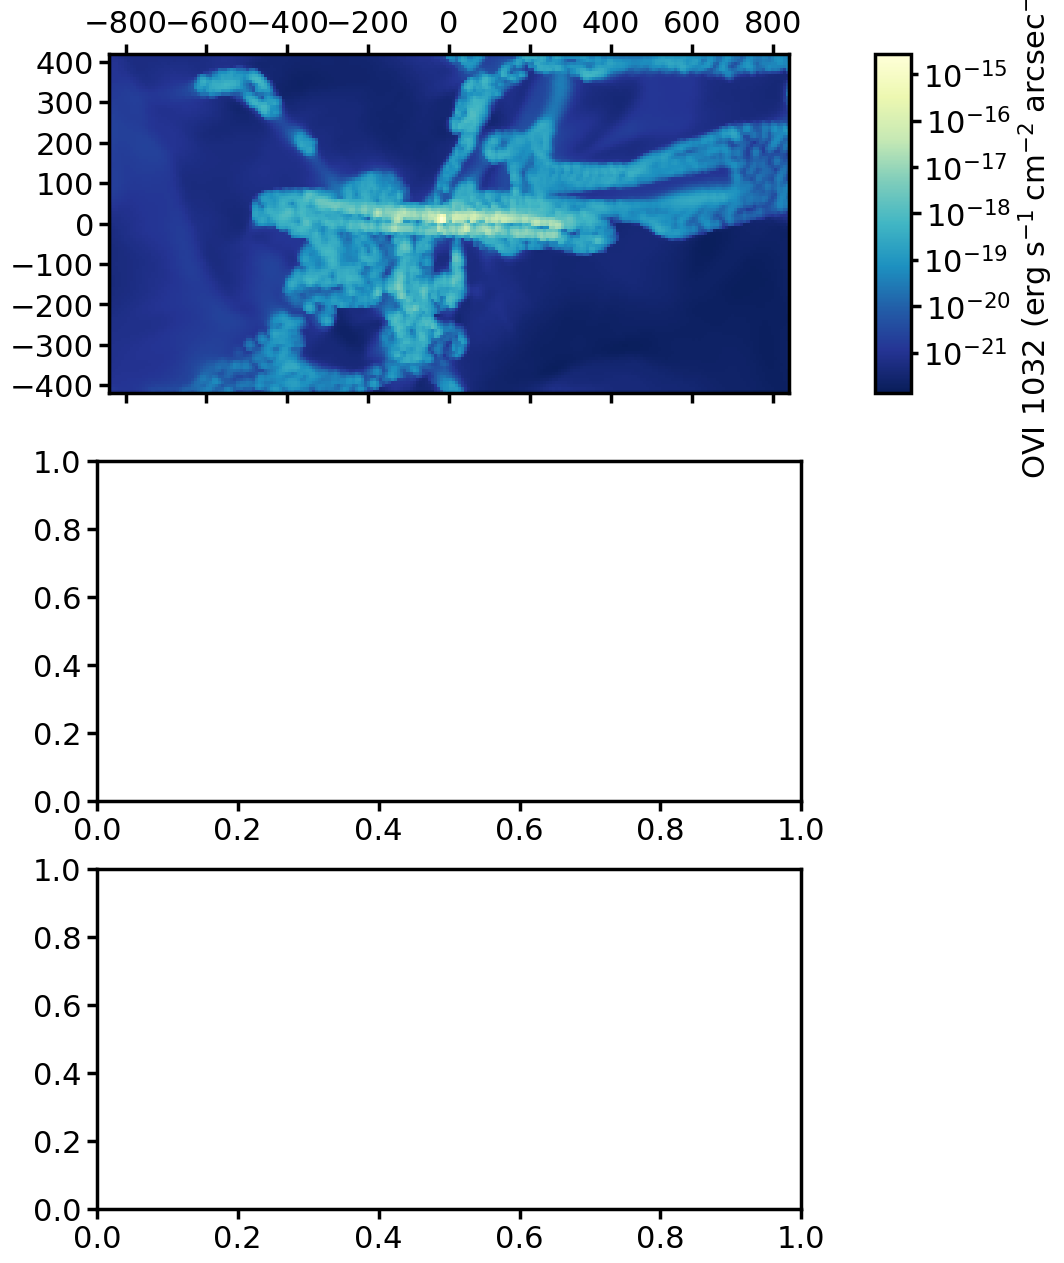

In [26]:


fig = plt.figure(figsize=(10.5*rr, 15*rr))
gs1 = gridspec.GridSpec(3, 2, figure=fig, width_ratios=[10,0.5])
ax=fig.add_subplot(gs1[0,0])
ax2=fig.add_subplot(gs1[1,0])
ax3=fig.add_subplot(gs1[2,0])

# ax=fig.add_subplot(2,1,1, zorder=0)
# ax2=fig.add_subplot(2,1,2, zorder=0)


# print(pim_after.shape)
# print(np.sum(bf))
# img=ax.imshow(np.log10(farr), extent=extent, cmap=cm.YlGnBu_r, 
#                   origin='lower', interpolation='none')
# img=ax.imshow(np.log10(show_im), extent=extent, cmap=cm.YlGnBu_r, 
#                   origin='lower', interpolation='none')
# img=ax.imshow(np.log10(pim*perg), extent=extent, cmap=cm.YlGnBu_r, 
#                   origin='lower', interpolation='none')

vmin, vmax=None, None
# vmin, vmax=None, 100
img=ax.matshow((pim*perg), extent=extent, cmap=cm.YlGnBu_r, 
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
                  origin='lower', interpolation='none')
ax2.tick_params(labeltop=False, labelbottom=True)

cax=fig.add_subplot(gs1[0,1])
cb=plt.colorbar(img, cax=cax, label='OVI 1032 '+r'$\rm(erg \;s^{-1} \;cm^{-2} \;arcsec^{-2})$')
# cb.ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
cb.ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=10))

#                 , format='%1.f', label='Count')



# img2=ax2.imshow(np.log10(ovi_count_map_fine), extent=extent, cmap=cm.YlGnBu_r, 
#                   origin='lower', interpolation='none')
              
map_fin_poisson=np.random.poisson(ovi_count_map_fine)
# img2=ax2.imshow(np.log10(map_fin_poisson+1), extent=extent, cmap=cm.YlGnBu_r, 
#                   origin='lower', interpolation='none')

vmin, vmax=None, None
vmin, vmax=None, 100
img2=ax2.matshow((map_fin_poisson+1)*(map_fin_poisson+1 > 0), extent=extent, cmap=cm.YlGnBu_r, 
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
                  origin='lower', interpolation='none')
ax2.tick_params(labeltop=False, labelbottom=True)

# cax.tick_params(axis='y', which='both', labelleft=True,left=True, labelright=False, right=False)

# img=ax.matshow(im, extent=extent, cmap=cmap, origin=origin, interpolation='none', 
#                       alpha=alpha, zorder=zorder, aspect=aspect, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))


# ovi_sn5=ovi_count_map_fine*(ovi_count_map_fine>25)
# img2=ax2.imshow(np.log10(ovi_sn5+1*0), extent=extent, cmap=cm.YlGnBu_r, 
#                   origin='lower', interpolation='none')


# plt.colorbar(img2)

cax2=fig.add_subplot(gs1[1,1])
cb2=plt.colorbar(img2, cax=cax2, format='%1.f', label='OVI Count')
# cb.ax.yaxis.set_label('Count')
# , ticks=(lcticks[i]),label=lclabels[i], format=cmlfmt[i])
# cb.cax.yaxis.set_label_position('right')
# #                 cb.ax.minorticks_on()
# cb.ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
# cax.tick_params(axis='y', which='both', labelleft=False,left=False, labelright=True, right=True)



vmin, vmax=None, None
vmin, vmax=None, 10
img3=ax3.matshow((map_fin_poisson**0.5)*(map_fin_poisson**0.5 > 3), extent=extent, cmap=cm.YlGnBu_r, 
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
                  origin='lower', interpolation='none')
ax3.tick_params(labeltop=False, labelbottom=True)

cax3=fig.add_subplot(gs1[2,1])
cb3=plt.colorbar(img3, cax=cax3, format='%1.f', label='OVI S/N')

#resolution 30*60

/tmp/ipykernel_690030/886322336.py:76: RuntimeWarning: invalid value encountered in divide
  img3=ax.matshow((map_fin_poisson/(map_fin_poisson+nbg)**0.5)*(map_fin_poisson/(map_fin_poisson+nbg)**0.5 > 3),


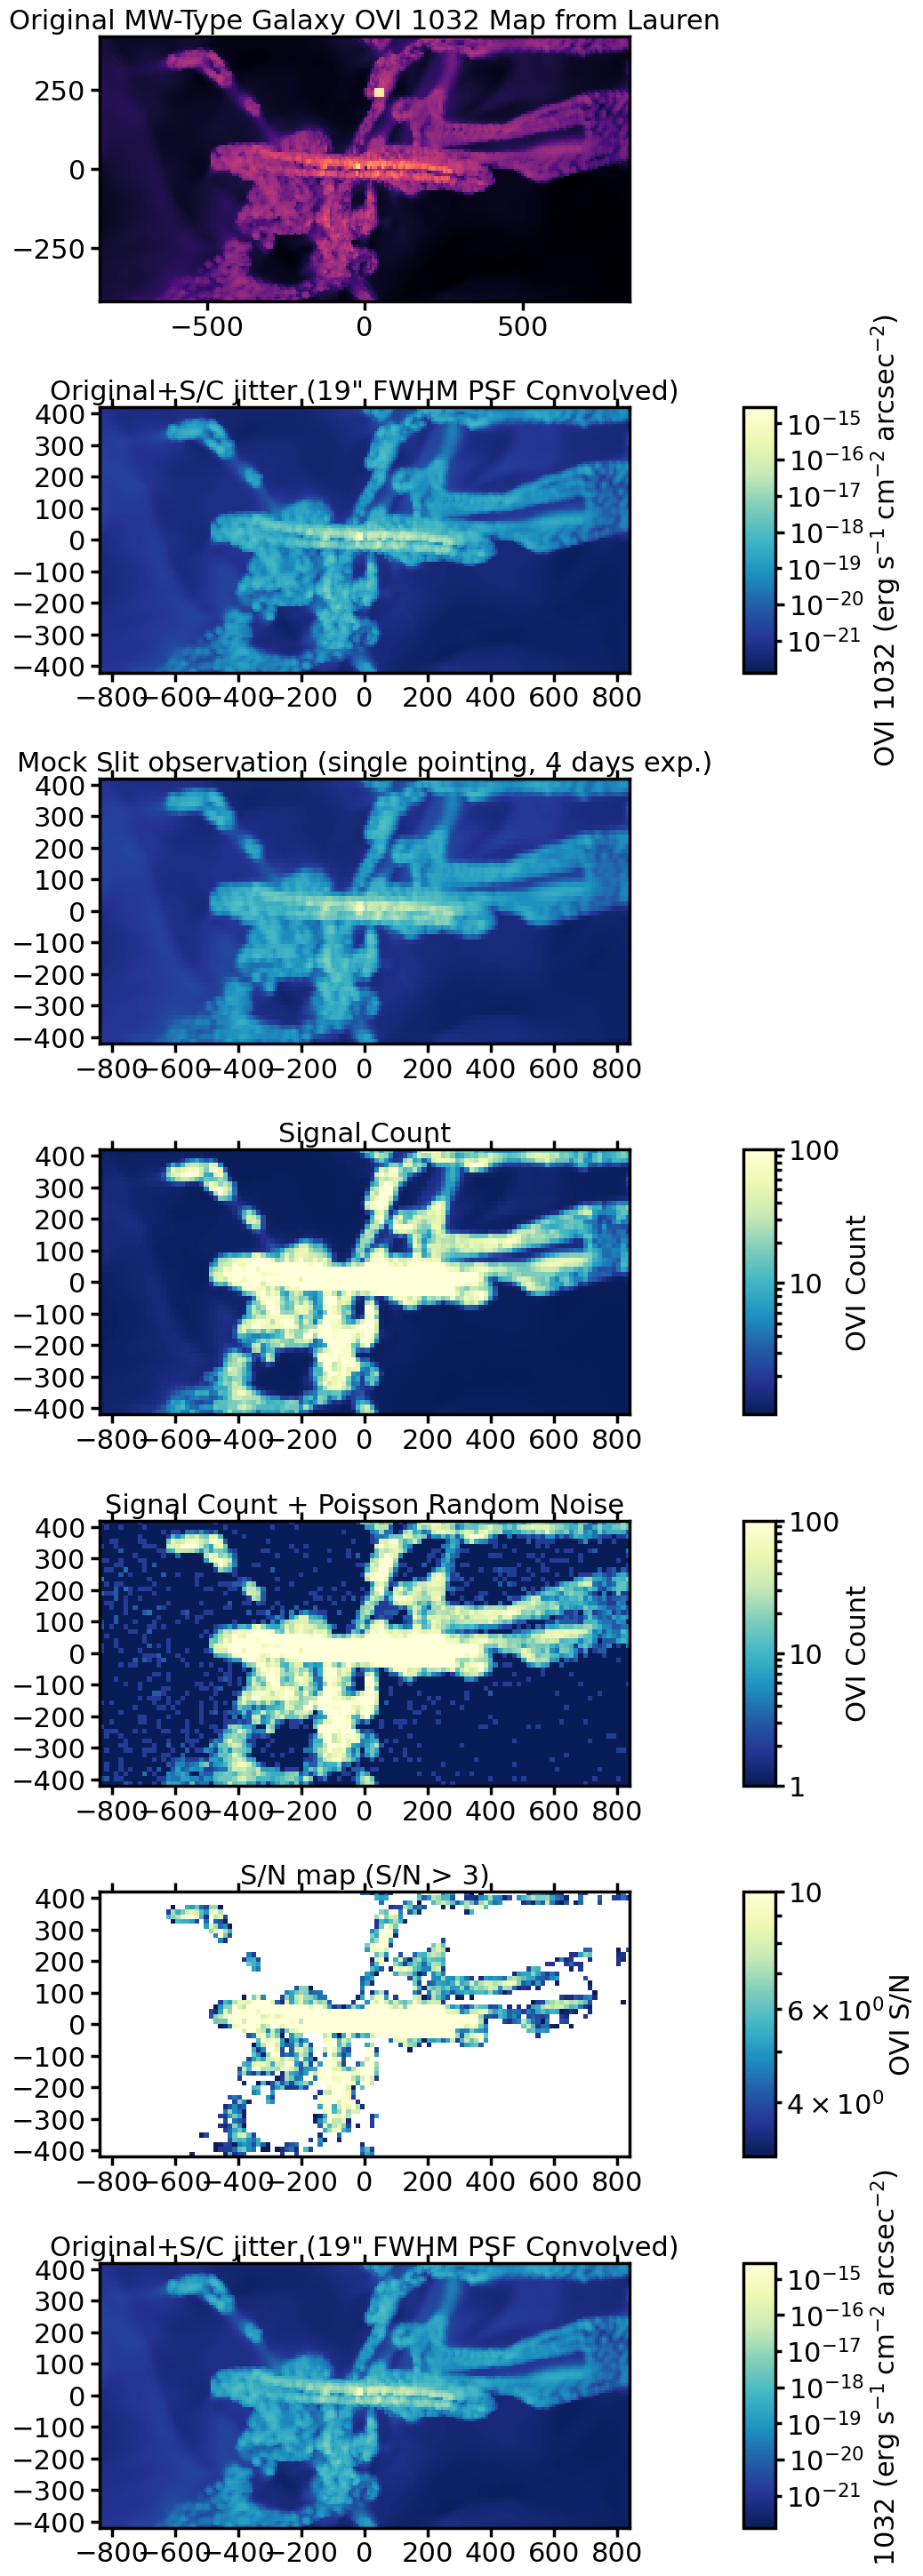

In [27]:
ovi_count_map_fine=farr

ngy=7
fig = plt.figure(figsize=(10.5*rr, ngy*5.2*rr))
gs1 = gridspec.GridSpec(ngy, 2, figure=fig, width_ratios=[10,0.5], hspace=0.4)

ni=0

ax=fig.add_subplot(gs1[ni,0])
img=ax.imshow(np.log10(show_im), extent=extent, 
              cmap=cm.magma,
                  origin='lower', interpolation='none')

ax.set_title('Original MW-Type Galaxy OVI 1032 Map from Lauren')

ni+=1
ax=fig.add_subplot(gs1[ni,0])
vmin, vmax=None, None
img=ax.matshow((pim*perg), extent=extent, cmap=cm.YlGnBu_r, 
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
                  origin='lower', interpolation='none')
ax.tick_params(labeltop=False, labelbottom=True)
ax.set_title('Original+S/C jitter (19" FWHM PSF Convolved)')

cax=fig.add_subplot(gs1[ni,1])
cb=plt.colorbar(img, cax=cax, label='OVI 1032 '+r'$\rm(erg \;s^{-1} \;cm^{-2} \;arcsec^{-2})$')
cb.ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=10))

ni+=1
ax=fig.add_subplot(gs1[ni,0])
vmin, vmax=None, None
img=ax.matshow((comb_arr_slit), extent=extent, cmap=cm.YlGnBu_r, 
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
                  origin='lower', interpolation='none')
ax.tick_params(labeltop=False, labelbottom=True)
ax.set_title('Mock Slit observation (single pointing, 4 days exp.)')

ni+=1
ax=fig.add_subplot(gs1[ni,0])
map_fin_poisson=ovi_count_map_fine.copy()

vmin, vmax=None, None
vmin, vmax=None, 100
img2=ax.matshow((map_fin_poisson+1)*(map_fin_poisson+1 > 0), extent=extent, cmap=cm.YlGnBu_r, 
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
                  origin='lower', interpolation='none')
ax.tick_params(labeltop=False, labelbottom=True)
ax.set_title('Signal Count')

cax=fig.add_subplot(gs1[ni,1])
cb2=plt.colorbar(img2, cax=cax, format='%1.f', label='OVI Count')

ni+=1
ax=fig.add_subplot(gs1[ni,0])
map_fin_poisson=np.random.poisson(ovi_count_map_fine)

vmin, vmax=None, None
vmin, vmax=None, 100
img2=ax.matshow((map_fin_poisson+1)*(map_fin_poisson+1 > 0), extent=extent, cmap=cm.YlGnBu_r, 
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
                  origin='lower', interpolation='none')
ax.tick_params(labeltop=False, labelbottom=True)
ax.set_title('Signal Count + Poisson Random Noise')

cax=fig.add_subplot(gs1[ni,1])
cb2=plt.colorbar(img2, cax=cax, format='%1.f', label='OVI Count')

ni+=1

ax=fig.add_subplot(gs1[ni,0])

vmin, vmax=None, None
vmin, vmax=None, 10
nbg=1
nbg=0
img3=ax.matshow((map_fin_poisson/(map_fin_poisson+nbg)**0.5)*(map_fin_poisson/(map_fin_poisson+nbg)**0.5 > 3), 
                extent=extent, cmap=cm.YlGnBu_r, 
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
                  origin='lower', interpolation='none')
ax.tick_params(labeltop=False, labelbottom=True)
ax.set_title('S/N map (S/N > 3)')

cax=fig.add_subplot(gs1[ni,1])
cb3=plt.colorbar(img3, cax=cax, format='%1.f', label='OVI S/N')

ni+=1
ax=fig.add_subplot(gs1[ni,0])
vmin, vmax=None, None
img=ax.matshow((pim*perg), extent=extent, cmap=cm.YlGnBu_r, 
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
                  origin='lower', interpolation='none')
ax.tick_params(labeltop=False, labelbottom=True)
ax.set_title('Original+S/C jitter (19" FWHM PSF Convolved)')


cax=fig.add_subplot(gs1[ni,1])
cb=plt.colorbar(img, cax=cax, label='OVI 1032 '+r'$\rm(erg \;s^{-1} \;cm^{-2} \;arcsec^{-2})$')
cb.ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=10))

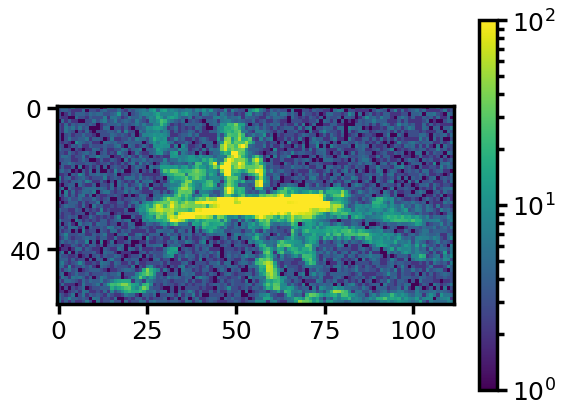

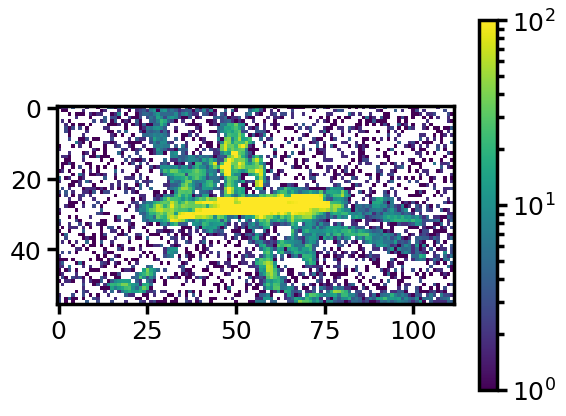

In [46]:
plt.imshow(map_fin_poisson+1, norm=LogNorm(vmin=1, vmax=100))
plt.colorbar()
plt.show()

plt.imshow(map_signal, norm=LogNorm(vmin=1, vmax=100))
plt.colorbar()
plt.show()

In [34]:
print(nbg)

0


4.375000000000001 3.1
(112,) (56,) (56, 112)
(56, 112) (56, 112) (56, 112)
xlim (0.0, 1.0)
1.095815396256344e-19 threq
x0, x1 0.0 0.0
fig_ovi_snrt_skipper.pdf


/tmp/ipykernel_690030/3017267055.py:46: RuntimeWarning: divide by zero encountered in divide
  map_snr=map_signal/map_noise
/tmp/ipykernel_690030/3017267055.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('magma')
/tmp/ipykernel_690030/3017267055.py:199: RuntimeWarning: divide by zero encountered in log10
  x0=np.log10(cxlim)
/tmp/ipykernel_690030/3017267055.py:202: RuntimeWarning: divide by zero encountered in log10
  x1=10**(np.log10(cxlim[0])-(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*1.7 )
/tmp/ipykernel_690030/3017267055.py:273: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('magma',12)


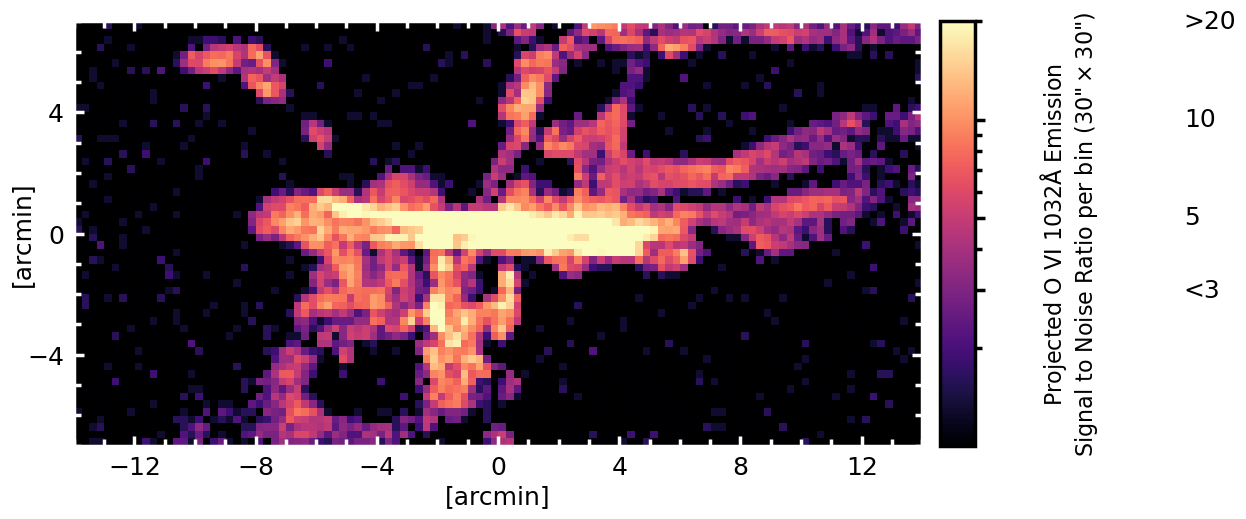

In [35]:
ngy=2
rr=1
# rr=2
# fig = plt.figure(figsize=(10.5*rr, ngy*5.2*rr))
# gs1 = gridspec.GridSpec(ngy, 2, figure=fig, width_ratios=[10,0.5], hspace=0.4)

set_rcparams_prop(amp=1.25, fs=18)
rtoa=180*3600/np.pi
bb=0.05
bb2=0.15/2
cbb=0.15
# wrs=np.array([0.25, 2, bb, 1.6, bb2, cbb, 0.25])
wrs=np.array([0.25, 
              0.25, 0.25,0.25,0.25,0.25,0.25,0.25,0.25,
              bb,
              0.25,0.25,0.25,0.25,0.3,0.3,
#               1.6, 
              bb2, cbb, 0.25])

# hrs=np.array([0.25, 2, bb, 1, 0.25])
hrs=np.array([0.25,0.75,0.1, 2])

aa=3
fig = plt.figure(figsize=(np.sum(wrs)*aa, np.sum(hrs)*aa))
# ax=fig.add_subplot(1,1,1, zorder=0)


print(np.sum(wrs),np.sum(hrs))
gs1 = gridspec.GridSpec(len(hrs), len(wrs), figure=fig, width_ratios=wrs, height_ratios=hrs,
                        hspace=0, wspace=0
                       )


ni=0
# ax=fig.add_subplot(gs1[ni,0])
# ax = fig.add_subplot(gs1[1, 1:4])
ax = fig.add_subplot(gs1[3, 1:16])

np.random.seed(seed=0)
# map_fin_poisson=np.random.poisson(ovi_count_map_fine)
map_fin_poisson=np.random.poisson(farr)+np.random.poisson(noise_count_arr)  # with random noise
# map_fin_poisson=farr.copy()  # without added noise

map_signal=map_fin_poisson-noise_count_arr
map_noise=(map_signal+noise_count_arr)**0.5
map_snr=map_signal/map_noise

# mcp_bg_count=noise_count_arr[0,0]
bgc=noise_count_arr[0,0]
snr=3.55
cut_signal=(snr**2+(snr**4+4*bgc*snr**2)**0.5)/2
# print(xxx, bgc)

# ocmf=ovi_count_map_fine
# mfp=map_fin_poisson

pextent=np.array(ovi_extent)/60

cfac=perg/exparr[0]/effarea/spatialbin_arcsec/slitw_arcsec
# pmap=(map_fin_poisson+1)*(map_fin_poisson+1 > 0)
pmap=(map_signal)*(map_signal > 0)
# pmap=map_fin_poisson
pmap=pmap*cfac

vmin, vmax=None, None
# vmin, vmax=1*cfac, 800*cfac
# vmin, vmax=1*cfac, 3e-17
# vmin, vmax=3e-20, 3e-17
# vmin, vmax=3e-20, 9e-17
# vmin, vmax=1, 50
vmin, vmax=1, 20
# vmin, vmax=2, 20
# pmap[10,2]=3e-17

# img2=ax.matshow(
#     pmap,
#                 extent=pextent, 
#                 cmap=cm.magma_r,
#                  norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
#     alpha=1, zorder=0,
#                   origin='lower', interpolation='none')

# cmap = cm.magma
cmap=cm.get_cmap('magma')
cmap.set_bad('k')

img2=ax.matshow(
#     pmap,
        map_snr,
#         map_snr*(map_snr>3),
# img2=ax.matshow(pmap*(mfp**0.5 > 3),
#                 pmap*(mfp**0.5 > 3),
#                 pmap*(mfp > 0),
#                 pmap*(map_snr>5),
                extent=pextent, 
#                 cmap=cm.magma_r,
#                 cmap=cm.magma,
                cmap=cmap,
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=0, alpha=1, 
    aspect='equal',
#     aspect='auto',
                  origin='lower', 
    interpolation='none',
#     interpolation='bicubic',
#     interpolation='bilinear',
)

# ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2])*(spatialbin_arcsec/slitw_arcsec))
# ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2])*(spatialbin_arcsec/slitw_arcsec)**(-1))
# ax.set_aspect((extent[3]-extent[2])/(extent[1]-extent[0])*(spatialbin_arcsec/slitw_arcsec)**(1))
ax.tick_params(labeltop=False, labelbottom=True)
# ax.set_title('Signal Count + Poisson Random Noise')


xv=np.arange(extent[0],extent[1], (extent[1]-extent[0])/pmap.shape[1])
yv=np.arange(extent[2],extent[3], (extent[3]-extent[2])/pmap.shape[0])
xx,yy = np.meshgrid(xv, yv)
# , sparse=True)
print(xv.shape, yv.shape, pmap.shape)
print(xx.shape, yy.shape, pmap.shape)
# ax.contour(xx,yy,map_fin_poisson**0.5, [5], colors='g')
# ax.contour(xx,yy,(map_fin_poisson**0.5).astype(int), [3,5,10], colors='g')

ax.xaxis.set_major_locator(MultipleLocator(4))
ax.yaxis.set_major_locator(MultipleLocator(4))

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
pad=5
# ax.tick_params(axis='both', which='both', direction='in', top=True, bottom=True, left=True, right=True,
#                color='w',
#                pad=pad)

pad=7
ax.tick_params(axis='both', which='both', direction='in', 
               color='w', pad=pad,
               left=True, right=True, top=True, bottom=True)
for spine in ax.spines.values():
    spine.set_edgecolor('w')

# ax.set_xlabel(r'$\rm\Delta$'+'RA (arcmin)')
# ax.set_ylabel(r'$\rm\Delta$'+'DEC (arcmin)')
# ax.set_xlabel(r'$\rm\Delta$'+'[arcmin]')
# ax.set_ylabel(r'$\rm\Delta$'+'[arcmin]')
ax.set_xlabel('[arcmin]')
ax.set_ylabel('[arcmin]', labelpad=(-5))
# txt='Aspera Mock Observation (32 days)'
txt='\n'.join(['Aspera Mock Observation SNR',
             'Target distance: 7.35 Mpc',
#              'Net exposure time: '+('%i' % (totalexp/24/3600/n_channel))+' days'
             'Exp. time: '+('%i' % (totalexp/24/3600/nslit))+' days per pointing',
#              'Exp. time: '+('%.1f' % (totalexp/24/3600/nslit))+' days per pointing',
               '(*: bin with SNR > 5)'
             ])

tclr='w'
txt=''
ax.text(13,-6, txt,
        fontsize=14, zorder=10, color=tclr, 
        horizontalalignment='right', 
#         verticalalignment='top',
        fontweight='bold')


dist=7.35 #Mpc, NED, 2013AJ 146 85 TRGB
arcmin_per_kpc=1/(dist*1000)*206265/60


gdx=(np.array([-1,1])/2*4+25)*arcmin_per_kpc
gdy=np.ones(2)*(12)*arcmin_per_kpc
# ax.plot(gdx,gdy,linewidth=5, color=tclr, linestyle='-')
# ax.text(np.sum(gdx)/2,gdy[0]-1*arcmin_per_kpc,'4 kpc', fontsize=15, zorder=10, color=tclr, 
#         horizontalalignment='center', verticalalignment='top',
#         fontweight='bold')


# cax=fig.add_subplot(gs1[ni,1])
# cax = fig.add_subplot(gs1[1, 5])
cax = fig.add_subplot(gs1[3, 17])
# cax.ticklabel_format(style='plain')

# cb2=plt.colorbar(img2, cax=cax, format='%.1e', label='OVI Count')
cblabel='OVI 1032 '+r'$\rm(erg \;s^{-1} \;cm^{-2} \;arcsec^{-2})$'
cblabel='Projected O VI 1032'+r'$\rm\AA$'+' Emission\n'+r'$\rm(erg \;s^{-1} \;cm^{-2} \;arcsec^{-2})$'
cblabel='Projected O VI 1032'+r'$\rm\AA$'+' Emission\nSignal to Noise Ratio per bin (30"'+r'$\rm\times$'+'30")'
cb2=plt.colorbar(img2, cax=cax, label=cblabel)
cax.set_ylabel(cblabel, labelpad=35)
cax.yaxis.label.set_size(16)
# cax.get_yaxis().get_major_formatter().set_scientific(False)
# cax.ticklabel_format(useOffset=False, style='plain', axis='y')


print('xlim',cax.get_xlim())
cxlim=cax.get_xlim()
threq=cut_signal*cfac
bsreq=26*cfac
aleng=0.9
x0=np.log10(cxlim)
x0=cxlim[0]
# x1=10**(np.log10(cxlim[0])-3)
x1=10**(np.log10(cxlim[0])-(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*1.7 )
# cbticks=[3,5,10,30]
# cbticks=[3,5,10]
cbticks=[5,10]
# cax.set_yticklabels([])
cax.set_yticks([3,5,10])


# xoff=0.06
# x0=10**(np.log10(cxlim[1])+xoff)
# x1=10**(np.log10(cxlim[1])+(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*2+xoff)

print(threq, 'threq')
print('x0, x1', x0, x1)


ctoff=7
for i in cbticks:
    cax.text(cxlim[1]*ctoff, i, str(i), zorder=10, size=18,
         verticalalignment='center',
        )

# cax.text(cxlim[1]*ctoff, 50, '>50', zorder=10, size=18,
#          verticalalignment='center',
#         )
cax.text(cxlim[1]*ctoff, 20, '>20', zorder=10, size=18,
         verticalalignment='center',
        )

# cax.text(cxlim[1]*ctoff, 1, '<1', zorder=10, size=18,
#          verticalalignment='center',
#         )
cax.text(cxlim[1]*ctoff, 3, '<3', zorder=10, size=18,
         verticalalignment='center',
        )

# ax2.annotate('', xy=(0,bsreq), xytext=(-aleng, bsreq), 
#              arrowprops=dict(arrowstyle="->",linewidth=3, color='grey'))

cax.set_yticklabels([])
# cax.set_yticks([])
# cax.yaxis.set_major_formatter(FormatStrFormatter(''))
# cax.yaxis.set_major_formatter(plt.NullFormatter())



ps=ax.get_position()
cps=cax.get_position()
pp=ps.get_points()
cpp=cps.get_points()
# print(pp)
# print(cpp)
# xr=cpp[1,0]-cpp[0,0]
# yr=pp[1,1]-pp[1,0]
# rr=0.05
cpp[0,1]=pp[0,1]
cpp[1,1]=pp[1,1]
# print(cpp)
# npp=cpp+np.array([[xr*rr,0],[-xr*rr,0]])
# npp=cpp+np.array([[xr*rr,0],[-xr*rr,0]])
# cps.set_points(npp)
cps.set_points(cpp)
cax.set_position(cps)


sub_map=map_snr
sub_map[np.isfinite(sub_map)==False]=0
yval=np.arange(len(sub_map))
xv=np.arange(sub_map.shape[1])
yv=np.arange(sub_map.shape[0])
xx,yy = np.meshgrid(xv, yv)
cmap2 = cm.get_cmap('magma',12)
cmap2.set_bad('w')


# offs=np.array([0,1,8,9,24,25])*(-1)
offs=np.array([0,1,8,24,25])*(-1)
oxi=0.05
oxw=0.15
oyw=0.075
oxgap=0.05

arcmin_per_pixel=(extent[1]-extent[0])/60/map_snr.shape[1]
app=arcmin_per_pixel
idx=14+56
# for idx in range(map_snr.size):
#     px=idx % map_snr.shape[1]
#     py=idx//map_snr.shape[1]
# #     if map_snr[py,px] <5:
#     if map_snr[py,px] <3:
#         continue
#     recx=px*app-map_snr.shape[1]/2*app
#     recy=py*app-map_snr.shape[0]/2*app
#     rsize=app
#     rxoff, ryoff= 0.25, 0.15
# #     print(px, py, recx, recy, 'rec xy', map_snr.shape, map_snr[py,px])
#     recpatch=matplotlib.patches.Rectangle((recx,recy), rsize, rsize, 
#     # recpatch=matplotlib.patches.Rectangle((0,0), 1,1, 
# #                                           linestyle='--',   
#                                           fill=False, 
#                                           hatch='///',
# #                                           edgecolor='w', 
#                                           lw=0.05, zorder=1)
# #     art=ax.add_artist(recpatch)
#     ax.text(recx+rxoff, recy+ryoff, '*', color='w', size=10, alpha=0.6,
#             horizontalalignment='center', verticalalignment='center',
#            )

ax.set_rasterized(True)


if case == 0:
    map_snr_skipper=map_snr.copy()
    fname='fig_ovi_snrt_skipper.pdf'
if case == 1:
    map_snr_emccd=map_snr.copy()
    fname='fig_ovi_snrt_emccd.pdf'
if case == 2:
    map_snr_mcp=map_snr.copy()
    fname='fig_ovi_snrt_mcp.pdf'
    
    
print(fname)
# fname='fig_ovi_snr.pdf'



# fname='fig_ovi_snr.jpg'
# fname='fig_ovi_snr_nothermal.pdf'
# fname='fig_ovi_snr_addthermal.pdf'
# fig.savefig(fname,dpi=256, bbox_inches='tight')
# fig.savefig(fname,dpi=512, bbox_inches='tight')
#mcp_bg=

In [47]:
#fff
for case in range(1):

    npix_cross_slit=im_slit_convolve.shape[int((saxis==0)*1+(saxis==1)*0)]
    slitw_pix=int(slitw_arcsec/ptoa)
    pi_pix=int(pi_arcsec/ptoa)
    nslit=npix_cross_slit//slitw_pix
    print('nslit aa', nslit)
    # exparr=np.ones(nslit)*4*24*3600
    exparr=np.ones(nslit)*2*24*3600
    exparr=np.ones(nslit)*10*3600*5
    # exparr=np.ones(nslit)*1.5*24*3600
    # exparr[[12,13,14,15]]=0.5*24*3600
    totalexp=np.sum(exparr)
    select_slit=[]
    # select_slit=[14,16,18,20]
    n_channel=4
    print('total exposure time (days):', totalexp/24/3600/n_channel)
    # mcp_bg=0.3
    # case=0
    # case=1
    # case=2
    if case == 0:
        mcp_bg, effarea=0.001/3600*28, 60  #skipper
    if case == 1:
        mcp_bg, effarea=0.001/3600*28+7/5000*0.1, 60  #emccd
    if case == 2:
        mcp_bg, effarea=0.3/(1000*10)**2*48*84, 20  #mcp

    # effarea=4*5*0.75**2*0.45*0.4
    # effarea=4*5*0.75**2*0.45*0.55

    # effarea=4*5*0.7357**2*0.46697*0.42383814
    # effarea=60
    # effarea=20

    # pixelsize_radian=mcppixel_size_micron/pscale/rtoa
    # ovi_count_map_fine=farr*texp*effarea*pixelsize_sqarcsec

    pi_arcsec=2
    # slitw_arcsec=30
    slitw_arcsec=15
    # slitw_arcsec=60
    comb_arr=convolve_psf_comb(im_slit_convolve, pi_arcsec, slitw_arcsec, ptoa, pscale, 
                          fwhm_func_image, fwhm_to_size, axis=saxis, select_slit=select_slit,
                               exparr=exparr, effarea=effarea)

    comb_arr_slit=comb_arr.copy()

    # pim_after=convolve_psf(pim, ptoa, pscale, fwhm_func, fwhm_to_size, axis=1)


    spatialbin_arcsec=30
    spatialbin_arcsec=15
    # spatialbin_arcsec=22.5
    binoff_arcsec=2
    farr=rebin_slit_direction(comb_arr, spatialbin_arcsec, binoff_arcsec, ptoa, pscale, axis=saxis)

    dispersion=1.489 #nm/mm
    spec_window=1 #Angstrom
    rseed=0
    print(mcp_bg, pscale, spatialbin_arcsec, slitw_arcsec, pscale*spatialbin_arcsec,pscale*slitw_arcsec)
    noise_count_arr=bg_noise(farr,mcp_bg, pscale, spatialbin_arcsec, dispersion, spec_window, exparr, 
                     axis=saxis, select_slit=select_slit)

    ngy=2
    rr=1
    # rr=2
    # fig = plt.figure(figsize=(10.5*rr, ngy*5.2*rr))
    # gs1 = gridspec.GridSpec(ngy, 2, figure=fig, width_ratios=[10,0.5], hspace=0.4)


    np.random.seed(seed=0)
    # map_fin_poisson=np.random.poisson(ovi_count_map_fine)
    map_fin_poisson=np.random.poisson(farr)+np.random.poisson(noise_count_arr)  # with random noise
    # map_fin_poisson=farr.copy()  # without added noise

    map_signal=map_fin_poisson-noise_count_arr
    map_noise=(map_signal+noise_count_arr)**0.5
    map_snr=map_signal/map_noise


    if case == 0:
        map_snr_skipper=map_snr.copy()
        fname='fig_ovi_snrt_skipper.pdf'
    if case == 1:
        map_snr_emccd=map_snr.copy()
        fname='fig_ovi_snrt_emccd.pdf'
    if case == 2:
        map_snr_mcp=map_snr.copy()
        fname='fig_ovi_snrt_mcp.pdf'

    


nslit aa 56
total exposure time (days): 29.166666666666668
nslit: 56
0
5
10
15
20
25
30
35
40
45
50
55
ori n spatial bin 224
spatialbin_pix, binoff_pix, npix_spatial 2 0 112
arr crop shape (56, 224)
new shape (56, 112)
7.777777777777777e-06 0.7757018897752576 15 15 11.635528346628863 11.635528346628863


/tmp/ipykernel_690030/3529944790.py:80: RuntimeWarning: divide by zero encountered in divide
  map_snr=map_signal/map_noise


In [48]:
maps=[map_snr_skipper, map_snr_emccd, map_snr_mcp]

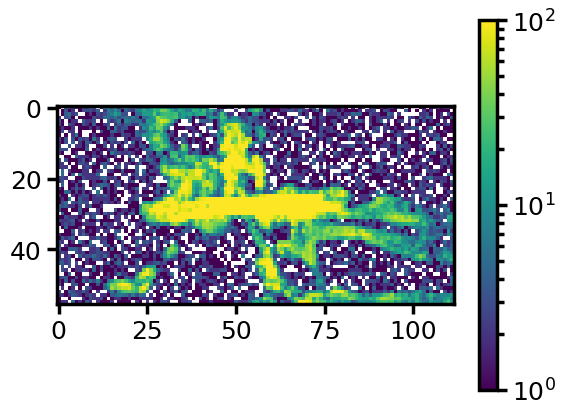

In [51]:
plt.imshow(map_fin_poisson, norm=LogNorm(vmin=1, vmax=100))
plt.colorbar()

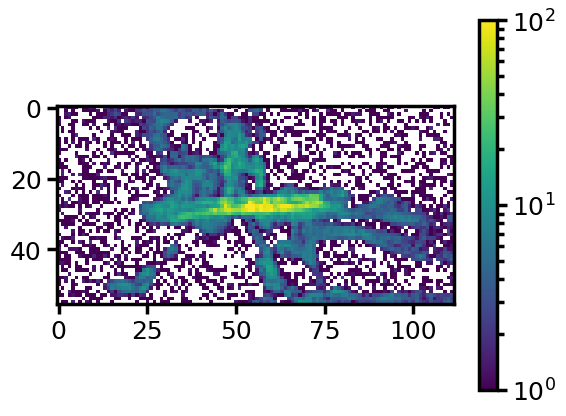

In [49]:
plt.imshow(map_snr_skipper, norm=LogNorm(vmin=1, vmax=100))
plt.colorbar()

In [50]:
print(noise_count_arr)

[[1.4 1.4 1.4 ... 1.4 1.4 1.4]
 [1.4 1.4 1.4 ... 1.4 1.4 1.4]
 [1.4 1.4 1.4 ... 1.4 1.4 1.4]
 ...
 [1.4 1.4 1.4 ... 1.4 1.4 1.4]
 [1.4 1.4 1.4 ... 1.4 1.4 1.4]
 [1.4 1.4 1.4 ... 1.4 1.4 1.4]]


In [53]:
print('{:.3e}'.format(0.001/3600*28))
print('{:.3e}'.format(0.001/3600*28+7/5000*0.1))

7.778e-06
1.478e-04


4.325 8
(112,) (56,) (56, 112)
(56, 112) (56, 112) (56, 112)
xlim (0.0, 1.0)
3.434654703375919e-19 threq
x0, x1 0.0 0.0
(112,) (56,) (56, 112)
(56, 112) (56, 112) (56, 112)
xlim (0.0, 1.0)
3.434654703375919e-19 threq
x0, x1 0.0 0.0
(112,) (56,) (56, 112)
(56, 112) (56, 112) (56, 112)
xlim (0.0, 1.0)
3.434654703375919e-19 threq
x0, x1 0.0 0.0
height in arcsec 841.8971683554954
New number of height and width pixels 112 224
sim extent [-13.905221548078691, 13.905221548078691, -6.9526107740393455, 6.9526107740393455]
2.8
xlim (0.0, 1.0)
1.64e-18 threq
x0, x1 0.0 0.0
x0 x1 1.15 inf


/tmp/ipykernel_681622/2321271655.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('magma')
/tmp/ipykernel_681622/2321271655.py:196: RuntimeWarning: divide by zero encountered in log10
  x0=np.log10(cxlim)
/tmp/ipykernel_681622/2321271655.py:199: RuntimeWarning: divide by zero encountered in log10
  x1=10**(np.log10(cxlim[0])-(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*1.7 )
/tmp/ipykernel_681622/2321271655.py:259: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('magma',12)
/tmp/ipykernel_681622/2321271655.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be 

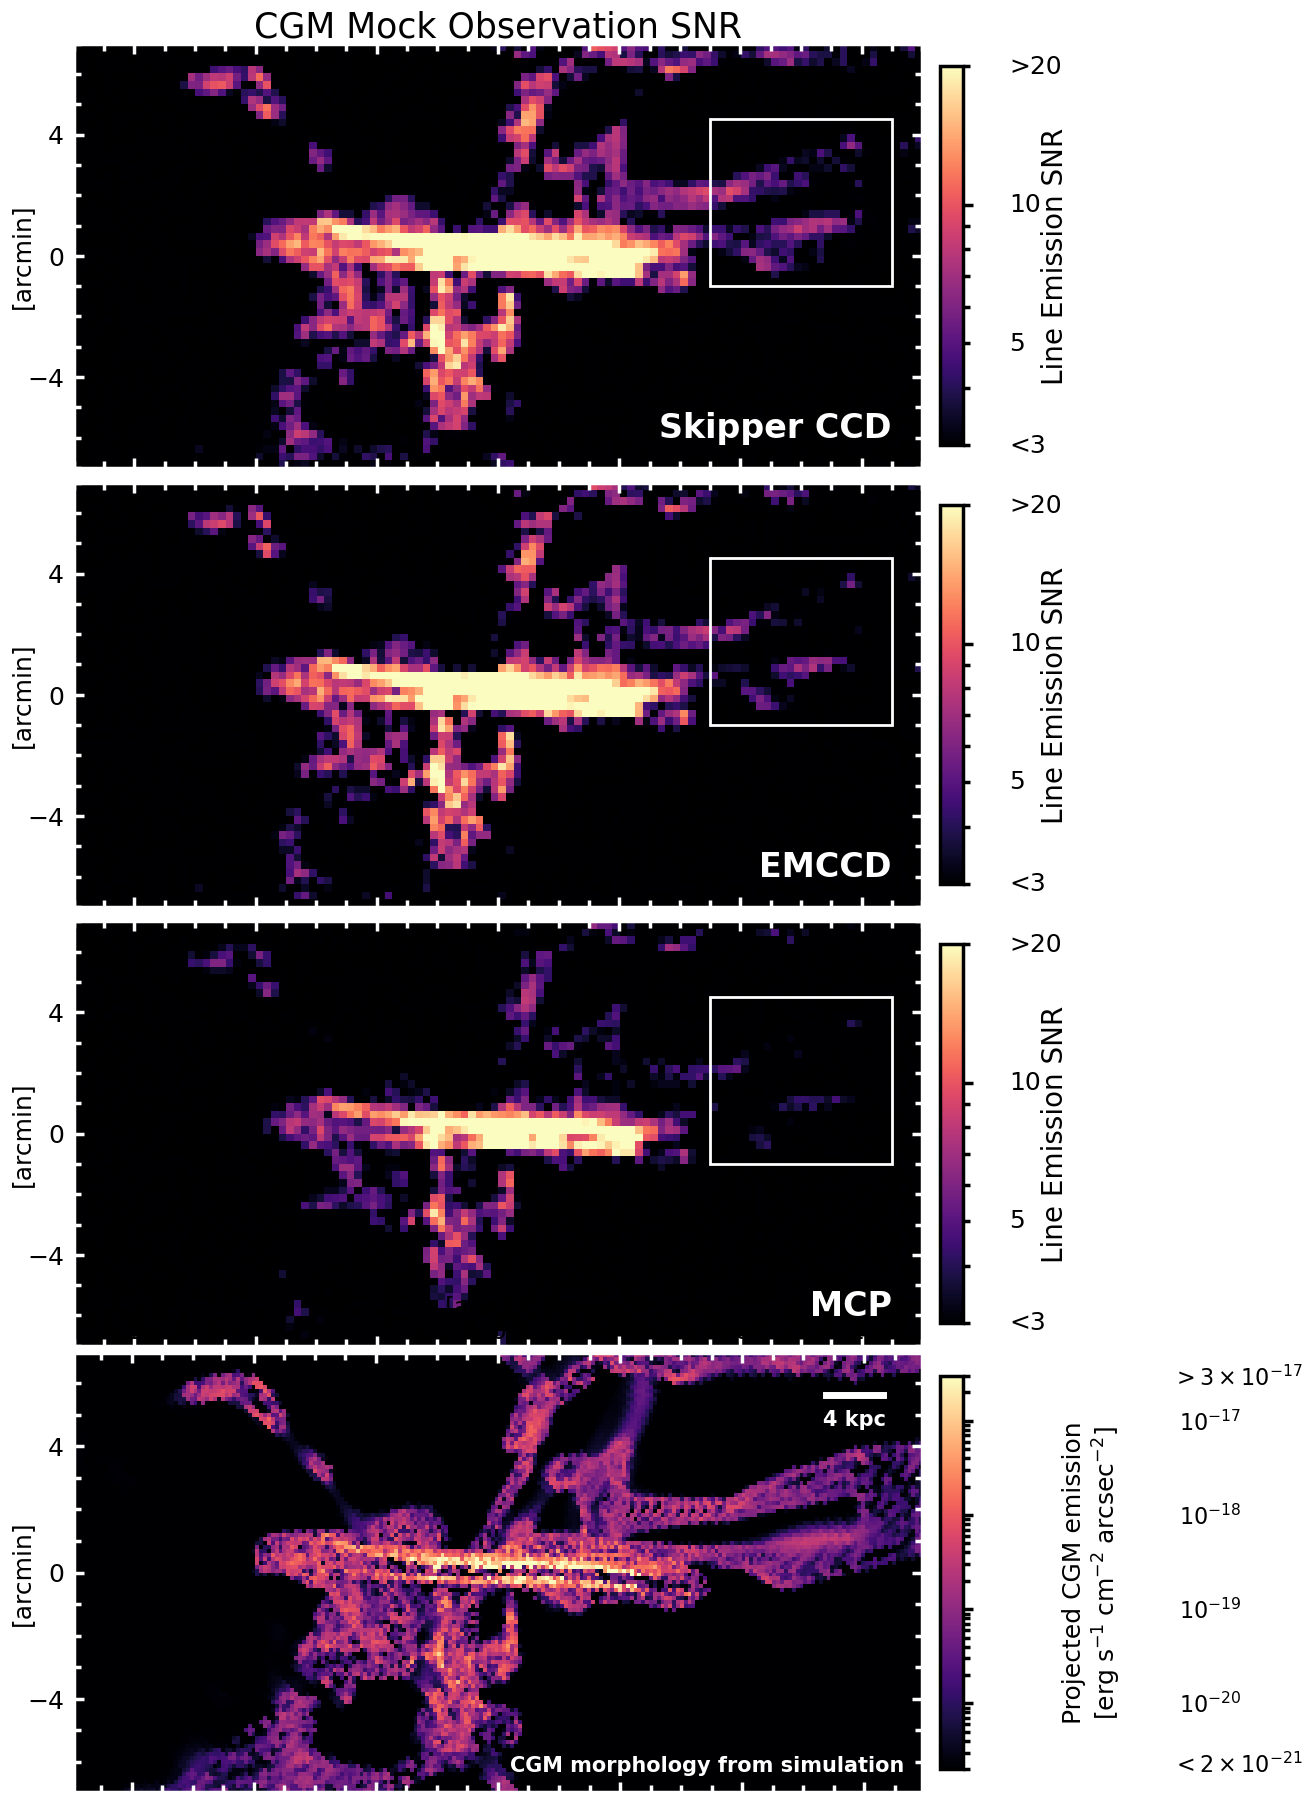

In [25]:
ngy=2
rr=1
# rr=2
# fig = plt.figure(figsize=(10.5*rr, ngy*5.2*rr))
# gs1 = gridspec.GridSpec(ngy, 2, figure=fig, width_ratios=[10,0.5], hspace=0.4)

set_rcparams_prop(amp=1.25, fs=18)
rtoa=180*3600/np.pi
bb=0.05
bb2=0.15/2
cbb=0.15
cbb=0.1
# wrs=np.array([0.25, 2, bb, 1.6, bb2, cbb, 0.25])
wrs=np.array([0.25, 
              0.25, 0.25,0.25,0.25,0.25,0.25,0.25,0.25,
              bb,
              0.25,0.25,0.25,0.25,0.3,0.3,
#               1.6, 
              bb2, cbb, 0.25])

# hrs=np.array([0.25, 2, bb, 1, 0.25])
# hrs=np.array([0.25,0.75,0.1, 2])
hrs=np.array([1,1,1,1])*2

aa=3
fig = plt.figure(figsize=(np.sum(wrs)*aa, np.sum(hrs)*aa*0.95))
# ax=fig.add_subplot(1,1,1, zorder=0)


print(np.sum(wrs),np.sum(hrs))
gs1 = gridspec.GridSpec(len(hrs), len(wrs), figure=fig, width_ratios=wrs, height_ratios=hrs,
                        hspace=0, wspace=0
                       )


ni=0
axs=[]
# ax=fig.add_subplot(gs1[ni,0])
# ax = fig.add_subplot(gs1[1, 1:4])
for i in range(3):
    axs.append(fig.add_subplot(gs1[i, 1:16]))

    
detector_txts=[
    'Detector: Skipper CCD',
    'Detector: EMCCD',
    'Detector: MCP',
]

detector_txts=[
    'Skipper CCD',
    'EMCCD',
    'MCP',
]
for i in range(3):

    ax=axs[i]

    map_snr=maps[i]

    # mcp_bg_count=noise_count_arr[0,0]
    bgc=noise_count_arr[0,0]
    snr=3.55
    cut_signal=(snr**2+(snr**4+4*bgc*snr**2)**0.5)/2

    pextent=np.array(ovi_extent)/60

    cfac=perg/exparr[0]/effarea/spatialbin_arcsec/slitw_arcsec


    vmin, vmax=None, None

    # vmin, vmax=1, 50
    vmin, vmax=3, 20
#     vmin, vmax=2, 20

    # cmap = cm.magma
    cmap=cm.get_cmap('magma')
    cmap.set_bad('k')

    img2=ax.matshow(
    #     pmap,
            map_snr,
    #         map_snr*(map_snr>3),
    # img2=ax.matshow(pmap*(mfp**0.5 > 3),
    #                 pmap*(mfp**0.5 > 3),
    #                 pmap*(mfp > 0),
    #                 pmap*(map_snr>5),
                    extent=pextent, 
    #                 cmap=cm.magma_r,
    #                 cmap=cm.magma,
                    cmap=cmap,
                     norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
        zorder=0, alpha=1, 
        aspect='equal',
    #     aspect='auto',
                      origin='lower', 
        interpolation='none',
    #     interpolation='bicubic',
    #     interpolation='bilinear',
    )

    # ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2])*(spatialbin_arcsec/slitw_arcsec))
    # ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2])*(spatialbin_arcsec/slitw_arcsec)**(-1))
    # ax.set_aspect((extent[3]-extent[2])/(extent[1]-extent[0])*(spatialbin_arcsec/slitw_arcsec)**(1))
    ax.tick_params(labeltop=False, labelbottom=True)
    # ax.set_title('Signal Count + Poisson Random Noise')


    xv=np.arange(extent[0],extent[1], (extent[1]-extent[0])/pmap.shape[1])
    yv=np.arange(extent[2],extent[3], (extent[3]-extent[2])/pmap.shape[0])
    xx,yy = np.meshgrid(xv, yv)
    # , sparse=True)
    print(xv.shape, yv.shape, pmap.shape)
    print(xx.shape, yy.shape, pmap.shape)
    # ax.contour(xx,yy,map_fin_poisson**0.5, [5], colors='g')
    # ax.contour(xx,yy,(map_fin_poisson**0.5).astype(int), [3,5,10], colors='g')

    ax.xaxis.set_major_locator(MultipleLocator(4))
    ax.yaxis.set_major_locator(MultipleLocator(4))

    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    pad=5
    # ax.tick_params(axis='both', which='both', direction='in', top=True, bottom=True, left=True, right=True,
    #                color='w',
    #                pad=pad)

    pad=7
    ax.tick_params(axis='both', which='both', direction='in', 
                   color='w', pad=pad,
                   left=True, right=True, top=True, bottom=True)
    for spine in ax.spines.values():
        spine.set_edgecolor('w')


    ax.set_xlabel('[arcmin]')
    ax.set_ylabel('[arcmin]', labelpad=(-5))
    # txt='Aspera Mock Observation (32 days)'
    det_txt=detector_txts[i]
    txt='\n'.join([
#         'CGM Mock Observation SNR',
                   det_txt,
#                  'Target distance: 7.35 Mpc',
    #              'Net exposure time: '+('%i' % (totalexp/24/3600/n_channel))+' days'
#                  'Exp. time: '+('%i' % (totalexp/24/3600/nslit))+' days per pointing',
    #              'Exp. time: '+('%.1f' % (totalexp/24/3600/nslit))+' days per pointing',
#                    '(*: bin with SNR > 5)'
                 ])

    tclr='w'
#     txt=''
    ax.text(13,-6, txt,
            fontsize=24, zorder=10, color=tclr, 
            horizontalalignment='right', 
    #         verticalalignment='top',
            fontweight='bold')
    if i < 2:
        ax.set_xticklabels([])
        ax.set_xlabel('')
        
    if i==0:
        ax.set_title('CGM Mock Observation SNR', size=25, pad=(-5))
    


    dist=7.35 #Mpc, NED, 2013AJ 146 85 TRGB
    arcmin_per_kpc=1/(dist*1000)*206265/60


    gdx=(np.array([-1,1])/2*4+25)*arcmin_per_kpc
    gdy=np.ones(2)*(12)*arcmin_per_kpc

    
    cax = fig.add_subplot(gs1[i, 17])
    # cax.ticklabel_format(style='plain')

    # cb2=plt.colorbar(img2, cax=cax, format='%.1e', label='OVI Count')
    cblabel='OVI 1032 '+r'$\rm(erg \;s^{-1} \;cm^{-2} \;arcsec^{-2})$'
    cblabel='Projected O VI 1032'+r'$\rm\AA$'+' Emission\n'+r'$\rm(erg \;s^{-1} \;cm^{-2} \;arcsec^{-2})$'
    cblabel='Projected O VI 1032'+r'$\rm\AA$'+' Emission\nSignal to Noise Ratio per bin (30"'+r'$\rm\times$'+'30")'
    cblabel='Line Emission SNR'
    cb2=plt.colorbar(img2, cax=cax, label=cblabel)
    cax.set_ylabel(cblabel, labelpad=45)
    cax.yaxis.label.set_size(20)
    cax.axes.yaxis.set_minor_formatter(ticker.NullFormatter())
    # cax.get_yaxis().get_major_formatter().set_scientific(False)
    # cax.ticklabel_format(useOffset=False, style='plain', axis='y')


    print('xlim',cax.get_xlim())
    cxlim=cax.get_xlim()
    threq=cut_signal*cfac
    bsreq=26*cfac
    aleng=0.9
    x0=np.log10(cxlim)
    x0=cxlim[0]
    # x1=10**(np.log10(cxlim[0])-3)
    x1=10**(np.log10(cxlim[0])-(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*1.7 )
    # cbticks=[3,5,10,30]
    # cbticks=[3,5,10]
    cbticks=[5,10]
#     cax.set_yticklabels(['','','',''])


    # xoff=0.06
    # x0=10**(np.log10(cxlim[1])+xoff)
    # x1=10**(np.log10(cxlim[1])+(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*2+xoff)

    print(threq, 'threq')
    print('x0, x1', x0, x1)


    ctoff=3
    for i in cbticks:
        cax.text(cxlim[1]*ctoff, i, str(i), zorder=10, size=18,
             verticalalignment='center',
            )

    # cax.text(cxlim[1]*ctoff, 50, '>50', zorder=10, size=18,
    #          verticalalignment='center',
    #         )
    cax.text(cxlim[1]*ctoff, 20, '>20', zorder=10, size=18,
             verticalalignment='center',
            )

    # cax.text(cxlim[1]*ctoff, 1, '<1', zorder=10, size=18,
    #          verticalalignment='center',
    #         )
    cax.text(cxlim[1]*ctoff, 3, '<3', zorder=10, size=18,
             verticalalignment='center',
            )

    cax.set_yticklabels([])


    ps=ax.get_position()
    cps=cax.get_position()
    pp=ps.get_points()
    cpp=cps.get_points()

    cpp[0,1]=pp[0,1]
    cpp[1,1]=pp[1,1]
    # print(cpp)
    cbyoff=0.01
    npp=cpp+np.array([[0,cbyoff],[0,-cbyoff]])
#     npp=cpp+np.array([[xr*rr,0],[-xr*rr,0]])
    cps.set_points(npp)
#     cps.set_points(cpp)
    cax.set_position(cps)


    sub_map=map_snr
    sub_map[np.isfinite(sub_map)==False]=0
    yval=np.arange(len(sub_map))
    xv=np.arange(sub_map.shape[1])
    yv=np.arange(sub_map.shape[0])
    xx,yy = np.meshgrid(xv, yv)
    cmap2 = cm.get_cmap('magma',12)
    cmap2.set_bad('w')


    # offs=np.array([0,1,8,9,24,25])*(-1)
    offs=np.array([0,1,8,24,25])*(-1)
    oxi=0.05
    oxw=0.15
    oyw=0.075
    oxgap=0.05

    arcmin_per_pixel=(extent[1]-extent[0])/60/map_snr.shape[1]
    app=arcmin_per_pixel
    idx=14+56

    ax.set_rasterized(True)
    
    rect = matplotlib.patches.Rectangle((7, -1), 6, 5.5, linewidth=2, edgecolor='w', 
                                        linestyle='-',
                                        facecolor='none')

# Add the patch to the Axes
    ax.add_patch(rect)


    
    

#MW galaxy sim

ax= fig.add_subplot(gs1[3, 1:16])

fname='edgeon_Ryan_z0_Emission_OVI_1032_270kpc.fits'
tt=fits.open(fname)
oim=np.transpose(tt['PRIMARY'].data, axes=(1,0))
# oim=tt['PRIMARY'].data
rtoa=180*3600/np.pi
perg=photon_energy(103.5)
psr2psqarc=1/rtoa**2
sig2fwhm=2*(2*np.log(2))**0.5
pscale=160*1000/rtoa
cim=oim.copy()/rtoa**2*perg   #convert unit of image from 'count/s/cm2/sr' to 'count/s/cm2/arcsec2'
cim=cim*norm_factor  #calibrate to have NGC4631-B brightness at its filament


subarcsec=7.5   #0.5 take too long time for convolution. 1.25 is appropriate


cfac=perg/exparr[0]/effarea/spatialbin_arcsec/slitw_arcsec
pmap=(map_signal)*(map_signal > 0)
pmap=pmap*cfac


# 737 pixels = 6.2 arcmin
# dist = 7.35 Mpc 
# widht= 6.2 arcmin * 7.35 = 6.2*60/206265*7.35*1000 = 13.256 kpc
# 737 pixels=13.256 kpc = 6.2 arcmin

img_height_in_kpc=30
# dist=1.05/(30/rtoa) #Mpc
dist=7.35 #Mpc, NED, 2013AJ 146 85 TRGB
img_height_in_arcsec=img_height_in_kpc/(dist*1000)*rtoa


arcsec_per_pixel=img_height_in_kpc/(dist*1000)*206265/cim.shape[0]
arcmin_per_pixel=img_height_in_kpc/(dist*1000)*206265/60/cim.shape[0]
kpc_per_pixel=img_height_in_kpc/cim.shape[1]
arcmin_per_kpc=1/(dist*1000)*206265/60

# y, x:  28:74
# ypix, xpix:   30 arcsec, 22.5 arcsec
# 28*30:74*22.5
npix_y=int(28*30/arcsec_per_pixel)
npix_x=npix_y*2
cim=cim[0:npix_y,0:npix_x]


print('height in arcsec', img_height_in_arcsec)
npix_height=int(np.round(img_height_in_arcsec/subarcsec))
npix_width=npix_height*2

# npix_width=int(np.round(img_height_in_arcsec/cim.shape[0]*cim.shape[1]/subarcsec))
print('New number of height and width pixels', npix_height, npix_width)
newdims=[npix_height, npix_width]

# im=congrid(cim, newdims, method='linear')   #project to new grid

cnt_ori=cim*(img_height_in_arcsec/oim.shape[0])**2
# cnt_after=im*(subarcsec)**2
 #sanity check: make sure total count is reserved
# print('Sanity Check (should be 1)',np.sum(cnt_ori)/np.sum(cnt_after)) 

ptoa=subarcsec

dx=subarcsec
dy=dx
x_center = cim.shape[1]//2
y_center = cim.shape[0]//2
x_extent = (np.array([0., cim.shape[1]]) - (cim.shape[1] - x_center)) * arcmin_per_pixel
y_extent = (np.array([0., cim.shape[0]]) - (cim.shape[0] - y_center)) * arcmin_per_pixel

extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

# oiv_sim_img=matplotlib.image.imread('oiv_sim.png')
# print(oiv_sim_img.shape,'imgshape')
# xr=np.array([-30,30])
# yr=np.array([-15,15])
print('sim extent', extent)


tclr='w'
vmin, vmax=None, None
vmin, vmax=None, 1e-16
vmin, vmax=None, 3e-17
vmin, vmax=1e-20, 3e-17
# vmin, vmax=2e-20, 3e-17
vmin, vmax=2e-21, 3e-17
# vmin, vmax=1*cfac, 3e-17
img=ax.matshow(
    cim,
                extent=extent, 
#                 cmap=cm.magma_r,
                cmap=cm.magma,
#                 cmap=cm.viridis,
                 norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=0, alpha=1, 
                  origin='lower', 
    interpolation='none',
    aspect='auto',
#     interpolation='bicubic',
#     interpolation='bilinear',
)


# img=ax.imshow(im, zorder=0, aspect='auto',origin='upper',
#               extent=extent,
#              )
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(axis='both', which='both', direction='in', 
               color=tclr,pad=pad,
               left=True, right=True, top=True, bottom=True)
for spine in ax.spines.values():
    spine.set_edgecolor(tclr)

xticksize=10
nxticks=((xr[1]-xr[0])/xticksize
        )
xticks=(np.arange(nxticks)-nxticks//2)*xticksize
# ax.set_xticklabels(xticks)
print(nxticks)
# ax.set_xlabel(r'$\rm\Delta$'+' Position (kpc)')
# ax.set_ylabel(r'$\rm\Delta$'+' Position (kpc)')
ax.set_xlabel('[arcmin]')
ax.set_ylabel('[arcmin]', labelpad=(-5))


ax.xaxis.set_major_locator(MultipleLocator(4))
ax.yaxis.set_major_locator(MultipleLocator(4))

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))




gdx=(np.array([-1,1])/2*4+25)*arcmin_per_kpc
gdy=np.ones(2)*(12)*arcmin_per_kpc
ax.plot(gdx,gdy,linewidth=5, color=tclr, linestyle='-')
ax.text(np.sum(gdx)/2,gdy[0]-1*arcmin_per_kpc,'4 kpc', fontsize=15, zorder=10, color=tclr, 
        horizontalalignment='center', verticalalignment='top',
        fontweight='bold')
# ax.text(28*arcmin_per_kpc,-13*arcmin_per_kpc,'MW-type galaxy simulation', fontsize=15, zorder=10, color=tclr, 
ax.text(28.5*arcmin_per_kpc,-13.5*arcmin_per_kpc,'CGM morphology from simulation', fontsize=15, zorder=10, color=tclr, 
        horizontalalignment='right', 
#         verticalalignment='top',
        fontweight='bold')
# ax.text(0.03,0.91,'(a)', fontsize=15, zorder=10, color=tclr, 
#         horizontalalignment='left', 
#         fontweight='bold',transform=ax.transAxes)




# dist=5 #Mpc
sams=30
# sams=10
skpc=sams/rtoa*dist*1e3*arcmin_per_kpc
# skpc=sams/60
# skpc=3*arcmin_per_kpc
skpc=0.6
srt=1

pa=(0.4,2.5)
pa=(0.8,4)
pa=(1.1,4.3)
pa=(0.8,4.1)
# pa=(-1.45,-2.5)
# cirpatch=matplotlib.patches.Circle(pa, radius=skpc, linestyle='--',
#                                           fill=False, edgecolor='w', lw=2, zorder=1)
# art=ax.add_artist(cirpatch)
# ax.text(pa[0]-skpc*srt, pa[1]+skpc*srt,'α', fontsize=18, zorder=10, color='w', 
#         horizontalalignment='right',
#         verticalalignment='bottom',
#         fontweight='bold')

# pa=(1.75,-2.25)
# cirpatch=matplotlib.patches.Circle(pa, radius=skpc, linestyle='--',
#                                           fill=False, edgecolor='w', lw=2, zorder=1)
# art=ax.add_artist(cirpatch)
# ax.text(pa[0]+skpc*srt, pa[1]-skpc*srt,'β', fontsize=15, zorder=10, color='w', 
#         horizontalalignment='left',
#         verticalalignment='top',
#         fontweight='bold')


# cax = fig.add_subplot(gs0[1, 5], label='clrbar')
cax = fig.add_subplot(gs1[3, 17], label='clrbar')
labelpad=15
labelpad=20
cblabel='Projected O VI 1032'+r'$\rm\AA$'+' Emission\n'+r'$\rm(erg \;s^{-1} \;cm^{-2} \;arcsec^{-2})$'
# cblabel='Projected\nO VI 1032'+r'$\rm\AA$'+'\nEmission\n'+r'$\rm(erg \;s^{-1} \;cm^{-2}$'+'\n'+r'$\rmarcsec^{-2})$'
cblabel='\n'.join(['Colorbar:',
    'Projected','O VI 1032'+r'$\rm\AA$','Emission',
        r'$\rm(erg \;s^{-1} \;cm^{-2}$',
         r'$\rmarcsec^{-2})$'
        ])

cblabel='Projected CGM emission\n['+r'$\rm erg \;s^{-1} \;cm^{-2} \;arcsec^{-2}$'+']'

cb2=plt.colorbar(img, cax=cax)
# cax.set_ylabel(cblabel, labelpad=labelpad)
# cax.set_ylabel(cblabel, labelpad=labelpad, horizontalalignment='left')
cax.set_ylabel(cblabel, labelpad=60)
# # cax.xaxis.set_label_position("top")
# cax.xaxis.set_label_position("bottom")
# label = cax.xaxis.get_label()
# x_lab_pos, y_lab_pos = label.get_position()
# # label.set_position([x_lab_pos*0.2, y_lab_pos])
# label.set_position([x_lab_pos*4.9, y_lab_pos])


print('xlim',cax.get_xlim())
cxlim=cax.get_xlim()
# threq=cut_signal*cfac
# bsreq=26*cfac
threq=1.64e-18
# bsreq=8.9e-19
bsreq=(8.9e-19)/3

# bsreq=8.9e-19

aleng=0.9
x0=np.log10(cxlim)
x0=cxlim[0]
# x1=10**(np.log10(cxlim[0])-3)
x1=10**(np.log10(cxlim[0])-(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*1.7 )

# xoff=0.06
# x0=10**(np.log10(cxlim[1])+xoff)
# x1=10**(np.log10(cxlim[1])+(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*2+xoff)


clr1=(53./256, 60./256, 80./256)
clr2=(.114, .151, .163)
clr2=(114/256, 151/256, 163/256)
clr3=(120/256, 94/256, 116/256)
clr4=(208/256, 107/256, 88/256)

print(threq, 'threq')
print('x0, x1', x0, x1)
# cax.annotate('', xy=(x0,threq), xytext=(x1, threq), 
#              arrowprops=dict(arrowstyle="->",linewidth=3, color=clr4), zorder=10)


# cax.annotate('', xy=(x0,bsreq), xytext=(x1, bsreq), 
#              arrowprops=dict(arrowstyle="->",linewidth=3, color=clr1), zorder=10)

# cax.text(x1*10, threq, 'test', zorder=10)



gg=' '
yticks=np.array([3e-17, 1e-17, 1e-18, 1e-19, 1e-20, 2e-21])
yticklabels=[
    r'$\rm > 3 \times 10^{-17}$',
    gg+r'$\rm 10^{-17}$',
    gg+r'$\rm 10^{-18}$',
    gg+r'$\rm 10^{-19}$',
    gg+r'$\rm 10^{-20}$',
    r'$\rm < 2 \times 10^{-21}$',
]
cax.set_yticklabels([])

for i in range(len(yticks)):
    offac=0.95
    if i==5:
        offac=1.1
    cax.text(cxlim[1]*10, yticks[i]*offac, yticklabels[i], zorder=10, size=16,
#     cax.text(cxlim[0]/10, yticks[i], yticklabels[i], zorder=10, size=16,
         verticalalignment='center',
#         horizontalalignment='right',
        )


# cax.text(cxlim[1]*10, 3*1e-17, r'$\rm > 3 \times 10^{-17}$', zorder=10, size=16,
#          verticalalignment='center',
#         )
cax.tick_params(labelsize=16)

ps=ax.get_position()
cps=cax.get_position()
pp=ps.get_points()
cpp=cps.get_points()

cpp[0,1]=pp[0,1]
cpp[1,1]=pp[1,1]
# print(cpp)
cbyoff=0.01
npp=cpp+np.array([[0,cbyoff],[0,-cbyoff]])
#     npp=cpp+np.array([[xr*rr,0],[-xr*rr,0]])
cps.set_points(npp)
#     cps.set_points(cpp)
cax.set_position(cps)

x0=cxlim[1]*1.15
# x0=cxlim[0]
# x1=10**(np.log10(x0)+(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*6 )
x1=10**(np.log10(x0)+(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*2*0.8 )
# x1=10**(np.log10(x0)-(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*6 )
print('x0 x1',x0, x1)

detec=np.log10(1.64e-18)-np.log10(2e-18)

pe=photon_energy(lam=103.2)
thlow=(3600*pe*(np.pi/180/3600)**2)
thnorm=(4600*pe*(np.pi/180/3600)**2)
thup=(5600*pe*(np.pi/180/3600)**2)
bsnorm=(2000/2*pe*(np.pi/180/3600)**2)

thlow2=((8000-1300)*pe*(np.pi/180/3600)**2)
thnorm2=(8000*pe*(np.pi/180/3600)**2)
thup2=((8000+1300)*pe*(np.pi/180/3600)**2)


thrange=np.log10(thup)-np.log10(thlow)
thmid=10**(np.log10(thlow)+thrange/2)

# cax.annotate('', xy=(x0,thlow), xytext=(x1, thlow), 
#              arrowprops=dict(arrowstyle="<-",linewidth=2, color='k'), zorder=10)
# cax.annotate('', xy=(x0,thup), xytext=(x1, thup), 
#              arrowprops=dict(arrowstyle="<-",linewidth=2, color='k'), zorder=10)

# thlb='Threshold Req.'
# cax.text(x0*10, thlow*1.1, thlb, size=15,
#          horizontalalignment='left', verticalalignment='bottom',
#         )

# cax.annotate(r"$\{$",fontsize=23,
#              horizontalalignment='right', verticalalignment='center',
#             xy=(x0,  dmid),)

# cax.annotate('', xy=(x0,thlow2), xytext=(x1, thlow2), 
#              arrowprops=dict(arrowstyle="-",linewidth=2, color='k'), zorder=10)
# cax.annotate('', xy=(x0,thup2), xytext=(x1, thup2), 
#              arrowprops=dict(arrowstyle="-",linewidth=2, color='k'), zorder=10)




# cyoff=0.014
# cyoff=0
# ps=ax.get_position()
# cps=cax.get_position()
# pp=ps.get_points()
# cpp=cps.get_points()
# print(pp)
# print(cpp)
# # xr=cpp[1,0]-cpp[0,0]
# # yr=pp[1,1]-pp[1,0]
# # rr=0.05
# cpp[0,1]=pp[0,1]
# cpp[1,1]=pp[1,1]

# cpp[0,1]=cpp[0,1]-cyoff
# cpp[1,1]=cpp[1,1]-cyoff

# pp[0,1]=pp[0,1]-cyoff
# pp[1,1]=pp[1,1]-cyoff

# print(cpp)
# # npp=cpp+np.array([[xr*rr,0],[-xr*rr,0]])
# # npp=cpp+np.array([[xr*rr,0],[-xr*rr,0]])
# # cps.set_points(npp)
# cps.set_points(cpp)
# cax.set_position(cps)
# ps.set_points(pp)
# ax.set_position(ps)
    


# fname='fig_ovi_snr.jpg'
# fname='fig_ovi_snr_nothermal.pdf'
# fname='fig_cgm_mock_snr.pdf'
fname='fig_cgm_mock_snr_withsim.pdf'
# fig.savefig(fname,dpi=256, bbox_inches='tight')
# fig.savefig(fname,dpi=512, bbox_inches='tight')


4.325 6
(112,) (56,) (56, 112)
(56, 112) (56, 112) (56, 112)
(112,) (56,) (56, 112)
(56, 112) (56, 112) (56, 112)
(112,) (56,) (56, 112)
(56, 112) (56, 112) (56, 112)
fig_ovi_snrt_mcp.pdf


/tmp/ipykernel_681622/2082117455.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('magma')
/tmp/ipykernel_681622/2082117455.py:231: RuntimeWarning: divide by zero encountered in log10
  x0=np.log10(cxlim)
/tmp/ipykernel_681622/2082117455.py:234: RuntimeWarning: divide by zero encountered in log10
  x1=10**(np.log10(cxlim[0])-(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*1.7 )
/tmp/ipykernel_681622/2082117455.py:308: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('magma',12)
/tmp/ipykernel_681622/2082117455.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will b

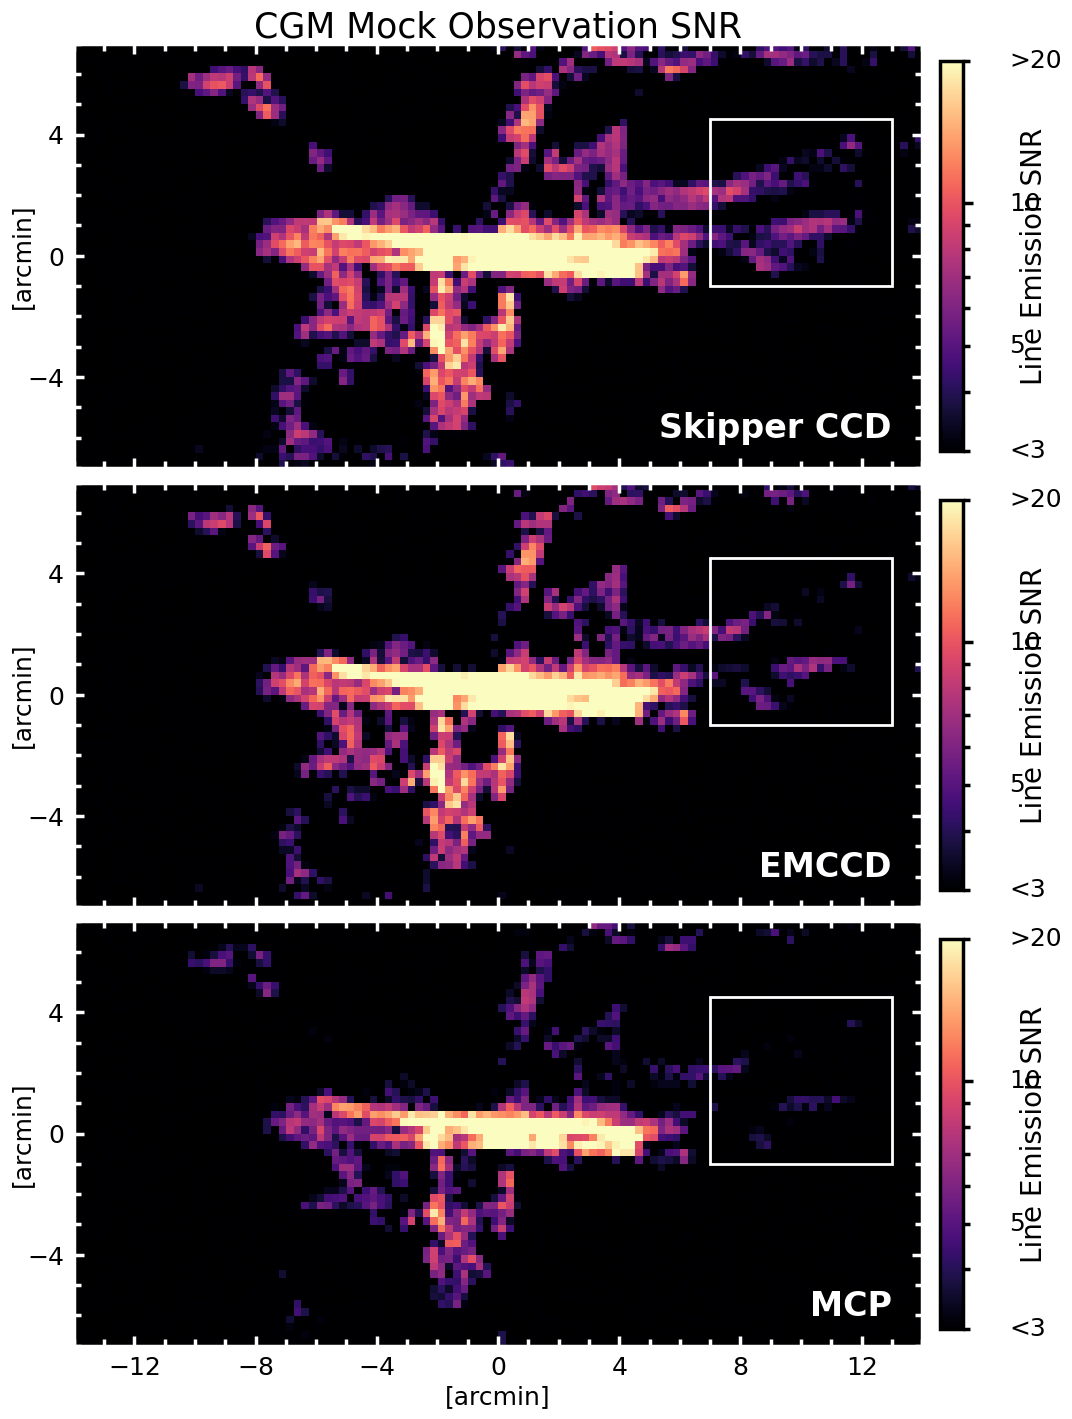

In [26]:
ngy=2
rr=1
# rr=2
# fig = plt.figure(figsize=(10.5*rr, ngy*5.2*rr))
# gs1 = gridspec.GridSpec(ngy, 2, figure=fig, width_ratios=[10,0.5], hspace=0.4)

set_rcparams_prop(amp=1.25, fs=18)
rtoa=180*3600/np.pi
bb=0.05
bb2=0.15/2
cbb=0.1
# wrs=np.array([0.25, 2, bb, 1.6, bb2, cbb, 0.25])
wrs=np.array([0.25, 
              0.25, 0.25,0.25,0.25,0.25,0.25,0.25,0.25,
              bb,
              0.25,0.25,0.25,0.25,0.3,0.3,
#               1.6, 
              bb2, cbb, 0.25])

# hrs=np.array([0.25, 2, bb, 1, 0.25])
# hrs=np.array([0.25,0.75,0.1, 2])
hrs=np.array([1,1,1])*2

aa=3
fig = plt.figure(figsize=(np.sum(wrs)*aa, np.sum(hrs)*aa*0.95))
# ax=fig.add_subplot(1,1,1, zorder=0)


print(np.sum(wrs),np.sum(hrs))
gs1 = gridspec.GridSpec(len(hrs), len(wrs), figure=fig, width_ratios=wrs, height_ratios=hrs,
                        hspace=0, wspace=0
                       )


ni=0
axs=[]
# ax=fig.add_subplot(gs1[ni,0])
# ax = fig.add_subplot(gs1[1, 1:4])
for i in range(3):
    axs.append(fig.add_subplot(gs1[i, 1:16]))

    
detector_txts=[
    'Detector: Skipper CCD',
    'Detector: EMCCD',
    'Detector: MCP',
]

detector_txts=[
    'Skipper CCD',
    'EMCCD',
    'MCP',
]
for i in range(3):

    ax=axs[i]
    # np.random.seed(seed=0)
    # # map_fin_poisson=np.random.poisson(ovi_count_map_fine)
    # map_fin_poisson=np.random.poisson(farr)+np.random.poisson(noise_count_arr)  # with random noise
    # # map_fin_poisson=farr.copy()  # without added noise

    # map_signal=map_fin_poisson-noise_count_arr
    # map_noise=(map_signal+noise_count_arr)**0.5
    # map_snr=map_signal/map_noise
    map_snr=maps[i]

    # mcp_bg_count=noise_count_arr[0,0]
    bgc=noise_count_arr[0,0]
    snr=3.55
    cut_signal=(snr**2+(snr**4+4*bgc*snr**2)**0.5)/2
    # print(xxx, bgc)

    # ocmf=ovi_count_map_fine
    # mfp=map_fin_poisson

    pextent=np.array(ovi_extent)/60

    cfac=perg/exparr[0]/effarea/spatialbin_arcsec/slitw_arcsec
    # # pmap=(map_fin_poisson+1)*(map_fin_poisson+1 > 0)
    # pmap=(map_signal)*(map_signal > 0)
    # # pmap=map_fin_poisson
    # pmap=pmap*cfac

    vmin, vmax=None, None
    # vmin, vmax=1*cfac, 800*cfac
    # vmin, vmax=1*cfac, 3e-17
    # vmin, vmax=3e-20, 3e-17
    # vmin, vmax=3e-20, 9e-17
    # vmin, vmax=1, 50
    vmin, vmax=3, 20
#     vmin, vmax=2, 20
    # vmin, vmax=2, 20
    # pmap[10,2]=3e-17

    # img2=ax.matshow(
    #     pmap,
    #                 extent=pextent, 
    #                 cmap=cm.magma_r,
    #                  norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
    #     alpha=1, zorder=0,
    #                   origin='lower', interpolation='none')

    # cmap = cm.magma
    cmap=cm.get_cmap('magma')
    cmap.set_bad('k')

    img2=ax.matshow(
    #     pmap,
            map_snr,
    #         map_snr*(map_snr>3),
    # img2=ax.matshow(pmap*(mfp**0.5 > 3),
    #                 pmap*(mfp**0.5 > 3),
    #                 pmap*(mfp > 0),
    #                 pmap*(map_snr>5),
                    extent=pextent, 
    #                 cmap=cm.magma_r,
    #                 cmap=cm.magma,
                    cmap=cmap,
                     norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
        zorder=0, alpha=1, 
        aspect='equal',
    #     aspect='auto',
                      origin='lower', 
        interpolation='none',
    #     interpolation='bicubic',
    #     interpolation='bilinear',
    )

    # ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2])*(spatialbin_arcsec/slitw_arcsec))
    # ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2])*(spatialbin_arcsec/slitw_arcsec)**(-1))
    # ax.set_aspect((extent[3]-extent[2])/(extent[1]-extent[0])*(spatialbin_arcsec/slitw_arcsec)**(1))
    ax.tick_params(labeltop=False, labelbottom=True)
    # ax.set_title('Signal Count + Poisson Random Noise')


    xv=np.arange(extent[0],extent[1], (extent[1]-extent[0])/pmap.shape[1])
    yv=np.arange(extent[2],extent[3], (extent[3]-extent[2])/pmap.shape[0])
    xx,yy = np.meshgrid(xv, yv)
    # , sparse=True)
    print(xv.shape, yv.shape, pmap.shape)
    print(xx.shape, yy.shape, pmap.shape)
    # ax.contour(xx,yy,map_fin_poisson**0.5, [5], colors='g')
    # ax.contour(xx,yy,(map_fin_poisson**0.5).astype(int), [3,5,10], colors='g')

    ax.xaxis.set_major_locator(MultipleLocator(4))
    ax.yaxis.set_major_locator(MultipleLocator(4))

    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    pad=5
    # ax.tick_params(axis='both', which='both', direction='in', top=True, bottom=True, left=True, right=True,
    #                color='w',
    #                pad=pad)

    pad=7
    ax.tick_params(axis='both', which='both', direction='in', 
                   color='w', pad=pad,
                   left=True, right=True, top=True, bottom=True)
    for spine in ax.spines.values():
        spine.set_edgecolor('w')

    # ax.set_xlabel(r'$\rm\Delta$'+'RA (arcmin)')
    # ax.set_ylabel(r'$\rm\Delta$'+'DEC (arcmin)')
    # ax.set_xlabel(r'$\rm\Delta$'+'[arcmin]')
    # ax.set_ylabel(r'$\rm\Delta$'+'[arcmin]')
    ax.set_xlabel('[arcmin]')
    ax.set_ylabel('[arcmin]', labelpad=(-5))
    # txt='Aspera Mock Observation (32 days)'
    det_txt=detector_txts[i]
    txt='\n'.join([
#         'CGM Mock Observation SNR',
                   det_txt,
#                  'Target distance: 7.35 Mpc',
    #              'Net exposure time: '+('%i' % (totalexp/24/3600/n_channel))+' days'
#                  'Exp. time: '+('%i' % (totalexp/24/3600/nslit))+' days per pointing',
    #              'Exp. time: '+('%.1f' % (totalexp/24/3600/nslit))+' days per pointing',
#                    '(*: bin with SNR > 5)'
                 ])

    tclr='w'
#     txt=''
    ax.text(13,-6, txt,
            fontsize=24, zorder=10, color=tclr, 
            horizontalalignment='right', 
    #         verticalalignment='top',
            fontweight='bold')
    if i < 2:
        ax.set_xticklabels([])
        ax.set_xlabel('')
        
    if i==0:
        ax.set_title('CGM Mock Observation SNR', size=25, pad=(-5))
    


    dist=7.35 #Mpc, NED, 2013AJ 146 85 TRGB
    arcmin_per_kpc=1/(dist*1000)*206265/60


    gdx=(np.array([-1,1])/2*4+25)*arcmin_per_kpc
    gdy=np.ones(2)*(12)*arcmin_per_kpc
    # ax.plot(gdx,gdy,linewidth=5, color=tclr, linestyle='-')
    # ax.text(np.sum(gdx)/2,gdy[0]-1*arcmin_per_kpc,'4 kpc', fontsize=15, zorder=10, color=tclr, 
    #         horizontalalignment='center', verticalalignment='top',
    #         fontweight='bold')


    # cax=fig.add_subplot(gs1[ni,1])
    # cax = fig.add_subplot(gs1[1, 5])
    cax = fig.add_subplot(gs1[i, 17])
    # cax.ticklabel_format(style='plain')

    # cb2=plt.colorbar(img2, cax=cax, format='%.1e', label='OVI Count')
    cblabel='OVI 1032 '+r'$\rm(erg \;s^{-1} \;cm^{-2} \;arcsec^{-2})$'
    cblabel='Projected O VI 1032'+r'$\rm\AA$'+' Emission\n'+r'$\rm(erg \;s^{-1} \;cm^{-2} \;arcsec^{-2})$'
    cblabel='Projected O VI 1032'+r'$\rm\AA$'+' Emission\nSignal to Noise Ratio per bin (30"'+r'$\rm\times$'+'30")'
    cblabel='Line Emission SNR'
    cb2=plt.colorbar(img2, cax=cax, label=cblabel)
    cax.set_ylabel(cblabel, labelpad=30)
    cax.yaxis.label.set_size(20)
    cax.axes.yaxis.set_minor_formatter(ticker.NullFormatter())
    # cax.get_yaxis().get_major_formatter().set_scientific(False)
    # cax.ticklabel_format(useOffset=False, style='plain', axis='y')


    # print('xlim',cax.get_xlim())
    cxlim=cax.get_xlim()
    threq=cut_signal*cfac
    bsreq=26*cfac
    aleng=0.9
    x0=np.log10(cxlim)
    x0=cxlim[0]
    # x1=10**(np.log10(cxlim[0])-3)
    x1=10**(np.log10(cxlim[0])-(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*1.7 )
    # cbticks=[3,5,10,30]
    # cbticks=[3,5,10]
    cbticks=[5,10]
#     cax.set_yticklabels(['','','',''])


    # xoff=0.06
    # x0=10**(np.log10(cxlim[1])+xoff)
    # x1=10**(np.log10(cxlim[1])+(np.log10(cxlim[1])-np.log10(cxlim[0]))*0.5*2+xoff)

    # print(threq, 'threq')
    # print('x0, x1', x0, x1)


    ctoff=3
    for i in cbticks:
        cax.text(cxlim[1]*ctoff, i, str(i), zorder=10, size=18,
             verticalalignment='center',
            )

    # cax.text(cxlim[1]*ctoff, 50, '>50', zorder=10, size=18,
    #          verticalalignment='center',
    #         )
    cax.text(cxlim[1]*ctoff, 20, '>20', zorder=10, size=18,
             verticalalignment='center',
            )

    # cax.text(cxlim[1]*ctoff, 1, '<1', zorder=10, size=18,
    #          verticalalignment='center',
    #         )
    cax.text(cxlim[1]*ctoff, 3, '<3', zorder=10, size=18,
             verticalalignment='center',
            )
#     cax.text(cxlim[1]*ctoff, 2, '<2', zorder=10, size=18,
#              verticalalignment='center',
#             )

    # ax2.annotate('', xy=(0,bsreq), xytext=(-aleng, bsreq), 
    #              arrowprops=dict(arrowstyle="->",linewidth=3, color='grey'))

    cax.set_yticklabels([])
    # cax.set_yticks([])
    # cax.yaxis.set_major_formatter(FormatStrFormatter(''))
    # cax.yaxis.set_major_formatter(plt.NullFormatter())



    ps=ax.get_position()
    cps=cax.get_position()
    pp=ps.get_points()
    cpp=cps.get_points()
    # print(pp)
    # print(cpp)
    # xr=cpp[1,0]-cpp[0,0]
    # yr=pp[1,1]-pp[1,0]
    # rr=0.05
    cpp[0,1]=pp[0,1]
    cpp[1,1]=pp[1,1]
    # print(cpp)
    cbyoff=0.01
    npp=cpp+np.array([[0,cbyoff],[0,-cbyoff]])
#     npp=cpp+np.array([[xr*rr,0],[-xr*rr,0]])
    cps.set_points(npp)
#     cps.set_points(cpp)
    cax.set_position(cps)


    sub_map=map_snr
    sub_map[np.isfinite(sub_map)==False]=0
    yval=np.arange(len(sub_map))
    xv=np.arange(sub_map.shape[1])
    yv=np.arange(sub_map.shape[0])
    xx,yy = np.meshgrid(xv, yv)
    cmap2 = cm.get_cmap('magma',12)
    cmap2.set_bad('w')


    # offs=np.array([0,1,8,9,24,25])*(-1)
    offs=np.array([0,1,8,24,25])*(-1)
    oxi=0.05
    oxw=0.15
    oyw=0.075
    oxgap=0.05

    arcmin_per_pixel=(extent[1]-extent[0])/60/map_snr.shape[1]
    app=arcmin_per_pixel
    idx=14+56
    # for idx in range(map_snr.size):
    #     px=idx % map_snr.shape[1]
    #     py=idx//map_snr.shape[1]
    # #     if map_snr[py,px] <5:
    #     if map_snr[py,px] <3:
    #         continue
    #     recx=px*app-map_snr.shape[1]/2*app
    #     recy=py*app-map_snr.shape[0]/2*app
    #     rsize=app
    #     rxoff, ryoff= 0.25, 0.15
    # #     print(px, py, recx, recy, 'rec xy', map_snr.shape, map_snr[py,px])
    #     recpatch=matplotlib.patches.Rectangle((recx,recy), rsize, rsize, 
    #     # recpatch=matplotlib.patches.Rectangle((0,0), 1,1, 
    # #                                           linestyle='--',   
    #                                           fill=False, 
    #                                           hatch='///',
    # #                                           edgecolor='w', 
    #                                           lw=0.05, zorder=1)
    # #     art=ax.add_artist(recpatch)
    #     ax.text(recx+rxoff, recy+ryoff, '*', color='w', size=10, alpha=0.6,
    #             horizontalalignment='center', verticalalignment='center',
    #            )

    ax.set_rasterized(True)
    
    rect = matplotlib.patches.Rectangle((7, -1), 6, 5.5, linewidth=2, edgecolor='w', 
                                        linestyle='-',
                                        facecolor='none')

# Add the patch to the Axes
    ax.add_patch(rect)


if case == 0:
    map_snr_skipper=map_snr.copy()
    fname='fig_ovi_snrt_skipper.pdf'
if case == 1:
    map_snr_emccd=map_snr.copy()
    fname='fig_ovi_snrt_emccd.pdf'
if case == 2:
    map_snr_mcp=map_snr.copy()
    fname='fig_ovi_snrt_mcp.pdf'
    
    
print(fname)
# fname='fig_ovi_snr.pdf'



# fname='fig_ovi_snr.jpg'
# fname='fig_ovi_snr_nothermal.pdf'
fname='fig_cgm_mock_snr.pdf'
# fig.savefig(fname,dpi=256, bbox_inches='tight')
# fig.savefig(fname,dpi=512, bbox_inches='tight')
